# Project: Reconstruction of flow field for a lid driven cavity flow

In [ ]:
from __future__ import print_function

import torch
from pyDOE import lhs
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

np.random.seed(1234)

: 

In [ ]:
print("Cuda availability: ", torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

: 

# Part (1) Forward problem: Compute the Solution using PINN

### Network setup:

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),

            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),

            nn.Linear(20, 2))                    
        
    def forward(self, x):
        return self.net(x)

### Function to evaluate derivatives

In [17]:
def function(self, x, y):
    nu = 0.01   # Re = 100

    res = self.net(torch.hstack((x, y)))
    psi, p = res[:, 0:1], res[:, 1:2]    # NN output: velocity field and pressure field 

    u = torch.autograd.grad(psi, y, grad_outputs=torch.ones_like(psi), create_graph=True)[0].to(device)
    v = -1.*torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0].to(device)

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0].to(device)
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0].to(device)
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0].to(device)
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0].to(device)

    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0].to(device)
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0].to(device)
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0].to(device)
    v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0].to(device)

    p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0].to(device)
    p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0].to(device)

    f = u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
    g = u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)

    return u, v, p, f, g

### Prepare boundary and residual points for training

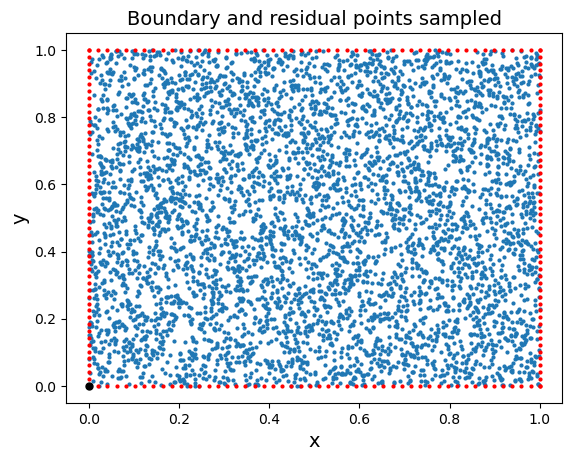

In [239]:
######### Origin ##########
x_origin = np.array([[0.]])
y_origin = np.array([[0.]])
x_origin_in = Variable(torch.from_numpy(np.reshape(x_origin, (-1, 1))).float(), requires_grad = True).to(device)
y_origin_in = Variable(torch.from_numpy(np.reshape(y_origin, (-1, 1))).float(), requires_grad = True).to(device) 


##### Boundary points #####
boundary_num = 50

# upper boundary
x_up = np.linspace(0., 1., boundary_num)
y_up = np.ones(boundary_num)
x_up_in = Variable(torch.from_numpy(np.reshape(x_up, (-1, 1))).float(), requires_grad = True).to(device)
y_up_in = Variable(torch.from_numpy(np.reshape(y_up, (-1, 1))).float(), requires_grad = True).to(device)   

# lower boundary
x_low = np.linspace(0., 1., boundary_num)
y_low = np.zeros(boundary_num)
x_low_in = Variable(torch.from_numpy(np.reshape(x_low, (-1, 1))).float(), requires_grad = True).to(device)
y_low_in = Variable(torch.from_numpy(np.reshape(y_low, (-1, 1))).float(), requires_grad = True).to(device)      

# left boundary
x_left = np.zeros(boundary_num)
y_left = np.linspace(0., 1., boundary_num)
x_left_in = Variable(torch.from_numpy(np.reshape(x_left, (-1, 1))).float(), requires_grad = True).to(device)
y_left_in = Variable(torch.from_numpy(np.reshape(y_left, (-1, 1))).float(), requires_grad = True).to(device)   

# right boundary
x_right = np.ones(boundary_num) 
y_right = np.linspace(0., 1., boundary_num)
x_right_in = Variable(torch.from_numpy(np.reshape(x_right, (-1, 1))).float(), requires_grad = True).to(device)
y_right_in = Variable(torch.from_numpy(np.reshape(y_right, (-1, 1))).float(), requires_grad = True).to(device)  


##### Residual points #####
res_num = 5000
res_pts = lhs(2, res_num)

x_res = res_pts[:, 0]
y_res = res_pts[:, 1]
x_res_in = Variable(torch.from_numpy(np.reshape(x_res, (-1, 1))).float(), requires_grad = True).to(device)
y_res_in = Variable(torch.from_numpy(np.reshape(y_res, (-1, 1))).float(), requires_grad = True).to(device)


######### Plotting ########
plt.plot(x_res, y_res, "o", markersize=2)
plt.plot(x_up, y_up, "ro", markersize=2)
plt.plot(x_left, y_left, "ro", markersize=2)
plt.plot(x_right, y_right, "ro", markersize=2)
plt.plot(x_low, y_low, "ro", markersize=2)
plt.plot(x_origin, y_origin, "ko", markersize=5)

plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.title("Boundary and residual points sampled", fontsize=14)
plt.show()

### Train network:

In [ ]:
net = Net()
print(net)
net = net.to(device)

##### Xavier Initialization #####
for m in net.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)


##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net.parameters(), lr=0.001)
loss_Adam = []

optimizer_LBFGS = torch.optim.LBFGS(net.parameters(), history_size=8, max_iter=500000)
loss_LBFGS = []


######### Training ########

#### Adam ####
N_iter_Adam = 10001
print("------ IN Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        
        ##### Origin #####
        u_origin, v_origin, p_origin, f_origin, g_origin = function(net, x_origin_in, y_origin_in)
        zero = torch.zeros(1, 1).to(device)
        loss_origin = mse_loss_func(p_origin, zero)     # pressure is 0 at origin

        ##### Boundary #####
        boundary_num = x_up_in.shape[0]
        zeros = torch.zeros(boundary_num, 1).to(device)
        ones = torch.ones(boundary_num, 1).to(device)

        # upper boundary 
        u_up, v_up, p_up, f_up, g_up = function(net, x_up_in, y_up_in)
        u_loss_up = mse_loss_func(u_up, ones)           # u = 1 at upper boundary 
        v_loss_up = mse_loss_func(v_up, zeros)          # v = 0 at upper boundary 
        loss_up = u_loss_up + v_loss_up

        # lower boundary 
        u_low, v_low, p_low, f_low, g_low = function(net, x_low_in, y_low_in)
        u_loss_low = mse_loss_func(u_low, zeros)        # u = 0 at lower boundary 
        v_loss_low = mse_loss_func(v_low, zeros)        # v = 0 at lower boundary 
        loss_low = u_loss_low + v_loss_low

        # left boundary 
        u_left, v_left, p_left, f_left, g_left = function(net, x_left_in, y_left_in)
        u_loss_left = mse_loss_func(u_left, zeros)      # u = 0 at lower boundary
        v_loss_left = mse_loss_func(v_left, zeros)      # v = 0 at lower boundary
        loss_left = u_loss_left + v_loss_left

        # right boundary 
        u_right, v_right, p_right, f_right, g_right = function(net, x_right_in, y_right_in)
        u_loss_right = mse_loss_func(u_right, zeros)        # u = 0 at lower boundary
        v_loss_right = mse_loss_func(v_right, zeros)        # v = 0 at lower boundary
        loss_right = u_loss_right + v_loss_right

        ##### Residual #####
        res_num = x_res_in.shape[0]
        zeros1 = torch.zeros(res_num, 1).to(device)

        u_res, v_res, p_res, f_res, g_res = function(net, x_res_in, y_res_in)
        f_loss_res = mse_loss_func(f_res, zeros1)       # to satisfy the PDE
        g_loss_res = mse_loss_func(g_res, zeros1)       # to satisfy the PDE
        loss_res = f_loss_res + g_loss_res

        # LOSS FUNCTION:
        loss = loss_origin + loss_up + loss_low + loss_left + loss_right + loss_res 
        loss.backward()
        return loss
       
    optimizer_adam.step(closure)
    loss = closure() 
    loss_Adam.append(loss.cpu().detach().numpy())
    
    if n%100 == 0:
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())


#### LBFGS ####
N_iter_LBFGS = 20
print("------ IN LBFGS ------")
for n in range(N_iter_LBFGS):
    def closure():
        optimizer_LBFGS.zero_grad()
        
        ##### Origin #####
        u_origin, v_origin, p_origin, f_origin, g_origin = function(net, x_origin_in, y_origin_in)
        zero = torch.zeros(1, 1).to(device)
        loss_origin = mse_loss_func(p_origin, zero)     # pressure is 0 at origin

        ##### Boundary #####
        boundary_num = x_up_in.shape[0]
        zeros = torch.zeros(boundary_num, 1).to(device)
        ones = torch.ones(boundary_num, 1).to(device)

        # upper boundary 
        u_up, v_up, p_up, f_up, g_up = function(net, x_up_in, y_up_in)
        u_loss_up = mse_loss_func(u_up, ones)           # u = 1 at upper boundary 
        v_loss_up = mse_loss_func(v_up, zeros)          # v = 0 at upper boundary 
        loss_up = u_loss_up + v_loss_up

        # lower boundary 
        u_low, v_low, p_low, f_low, g_low = function(net, x_low_in, y_low_in)
        u_loss_low = mse_loss_func(u_low, zeros)        # u = 0 at lower boundary 
        v_loss_low = mse_loss_func(v_low, zeros)        # v = 0 at lower boundary 
        loss_low = u_loss_low + v_loss_low

        # left boundary 
        u_left, v_left, p_left, f_left, g_left = function(net, x_left_in, y_left_in)
        u_loss_left = mse_loss_func(u_left, zeros)      # u = 0 at lower boundary
        v_loss_left = mse_loss_func(v_left, zeros)      # v = 0 at lower boundary
        loss_left = u_loss_left + v_loss_left

        # right boundary 
        u_right, v_right, p_right, f_right, g_right = function(net, x_right_in, y_right_in)
        u_loss_right = mse_loss_func(u_right, zeros)        # u = 0 at lower boundary
        v_loss_right = mse_loss_func(v_right, zeros)        # v = 0 at lower boundary
        loss_right = u_loss_right + v_loss_right

        ##### Residual #####
        res_num = x_res_in.shape[0]
        zeros1 = torch.zeros(res_num, 1).to(device)

        u_res, v_res, p_res, f_res, g_res = function(net, x_res_in, y_res_in)
        f_loss_res = mse_loss_func(f_res, zeros1)       # to satisfy the PDE
        g_loss_res = mse_loss_func(g_res, zeros1)       # to satisfy the PDE
        loss_res = f_loss_res + g_loss_res

        # LOSS FUNCTION:
        loss = loss_origin + loss_up + loss_low + loss_left + loss_right + loss_res 
        loss.backward()
        return loss

    optimizer_LBFGS.step(closure)
    loss = closure() 
    loss_LBFGS.append(loss.cpu().detach().numpy())
    
    print("LBFGS - Epoch: ", n, "Training Loss: ", loss.item())

Net(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): Tanh()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): Tanh()
    (14): Linear(in_features=20, out_features=2, bias=True)
  )
)
------ IN Adam ------
Adam - Epoch:  0 Training Loss:  1.061879277229309
Adam - Epoch:  100 Training Loss:  0.08023711293935776
Adam - Epoch:  200 Training Loss:  0.07755573838949203
Adam - Epoch:  300 Training Loss:  0.07720281928777695
Adam - Epoch:  400 Training Loss:  0.07715955376625061
Adam - Epoch:  500 Training Loss:  0.07655934989452362
Adam - Epoch:  600 Traini

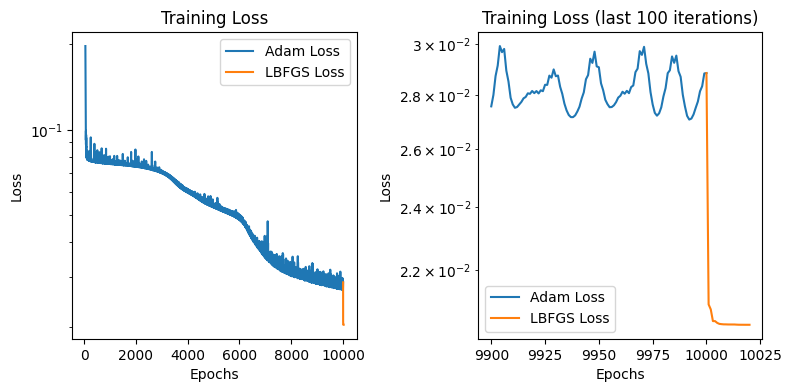

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=False)

ep1 = np.arange(50, N_iter_Adam)
ep2 = np.arange(N_iter_Adam - 1, N_iter_Adam + N_iter_LBFGS)

loss_LBFGS1 = [loss_Adam[-1]] + loss_LBFGS
axs[0].semilogy(ep1, loss_Adam[50:], label="Adam Loss")
axs[0].semilogy(ep2, loss_LBFGS1, label="LBFGS Loss")
axs[0].legend()
axs[0].set_title('Training Loss' )
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

ep3 = np.arange(9900, N_iter_Adam)
ep4 = np.arange(N_iter_Adam - 1, N_iter_Adam + N_iter_LBFGS)
axs[1].semilogy(ep3, loss_Adam[9900:], label="Adam Loss")
axs[1].semilogy(ep4, loss_LBFGS1, label="LBFGS Loss")
axs[1].legend()
axs[1].set_title('Training Loss (last 100 iterations)' )
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')

fig.tight_layout(pad=1.0)
plt.show()

### Graph the PINN solution

In [ ]:
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

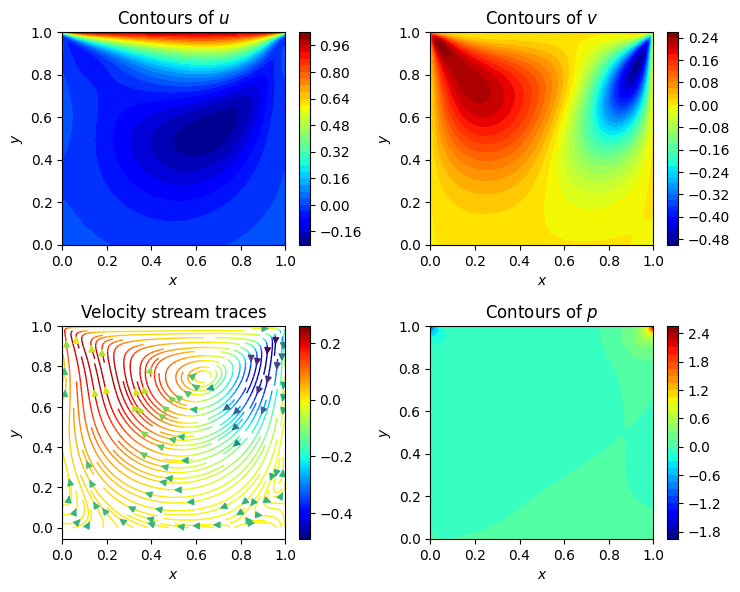

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200

xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
u, v, p = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, u, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Contours of $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, v, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Contours of $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, u, v, color=v, density=1.5, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Velocity stream traces' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, p, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Contours of $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

### Find l2 error

In [ ]:
# Load data from .mat file
velocity_data = scipy.io.loadmat('./velocity.mat')
pressure_data = scipy.io.loadmat('./pressure.mat')

# already flattened data
x = velocity_data['x'].T # 20201 x 1
y = velocity_data['y'].T # 20201 x 1
u = velocity_data['u'].T # 20201 x 1
v = velocity_data['v'].T # 20201 x 1
p = pressure_data['p'].T # 20201 x 1

In [ ]:
######### Calculate l2 loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.00055129395
7.889442e-05
0.00095073396
0.0025546993


# Part (2) Recover the flow for the entire domain from data points randomly sampled inside a patch

### 10, 100, 1000, 5000 data points

### Prepare data: points randomly sampled from a patch inside the domain.

In [11]:
# Load data from .mat file
velocity_data = scipy.io.loadmat('./velocity.mat')
pressure_data = scipy.io.loadmat('./pressure.mat')

# already flattened data
x = velocity_data['x'].T # 20201 x 1
y = velocity_data['y'].T # 20201 x 1
u = velocity_data['u'].T # 20201 x 1
v = velocity_data['v'].T # 20201 x 1
p = pressure_data['p'].T # 20201 x 1

In [13]:
# randomly sample N points from a square patch
def sample_in_patch(N, left, right):
    len = x.shape[0]
    x_train = np.array([])
    y_train = np.array([])
    u_train = np.array([])
    v_train = np.array([])
    p_train = np.array([])
    
    i = 0
    while i <= N:
        idx = np.random.choice(len, 1, replace=False)
        x_sample = x[idx,:]
        y_sample = y[idx,:]
        u_sample = u[idx,:]
        v_sample = v[idx,:]
        p_sample = p[idx,:]
        
        if left <= x_sample <= right and left <= y_sample <= right: # within the patch
            i = i + 1
            x_train = np.append(x_train, x_sample)
            y_train = np.append(y_train, y_sample)
            u_train = np.append(u_train, u_sample)
            v_train = np.append(v_train, v_sample)
            p_train = np.append(p_train, p_sample)      
   
    return x_train, y_train, u_train, v_train, p_train

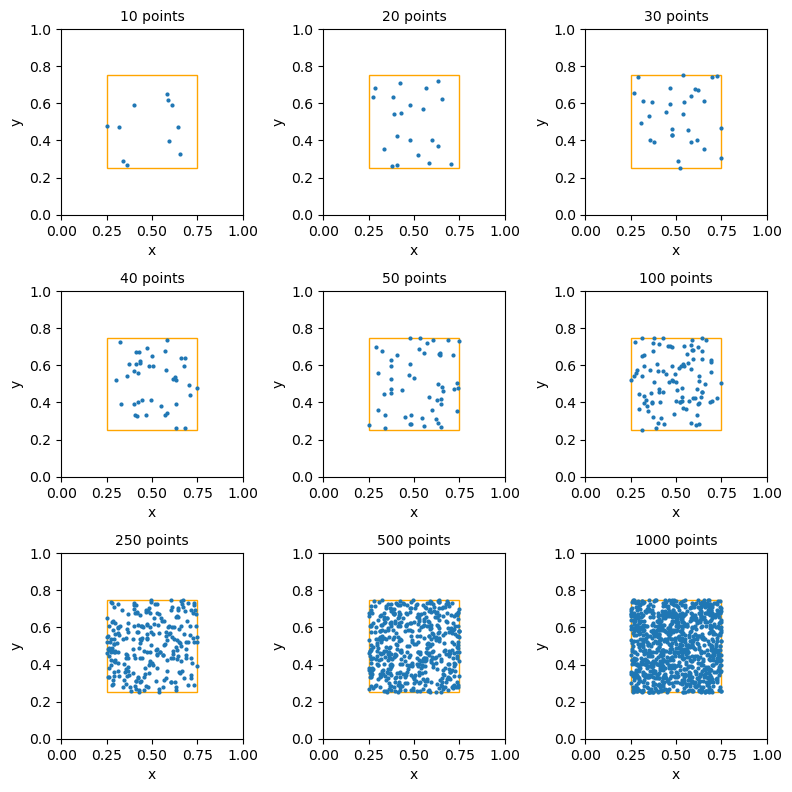

In [172]:
# Sample random points inside the sqaure patch
left = 0.25
right = 0.75

x_10, y_10, u_10, v_10, p_10 = sample_in_patch(10, left, right)
x_20, y_20, u_20, v_20, p_20 = sample_in_patch(20, left, right)
x_30, y_30, u_30, v_30, p_30 = sample_in_patch(30, left, right)
x_40, y_40, u_40, v_40, p_40 = sample_in_patch(40, left, right)
x_50, y_50, u_50, v_50, p_50 = sample_in_patch(50, left, right)
x_100, y_100, u_100, v_100, p_100 = sample_in_patch(100, left, right)
x_250, y_250, u_250, v_250, p_250 = sample_in_patch(250, left, right)
x_500, y_500, u_500, v_500, p_500 = sample_in_patch(500, left, right)
x_1000, y_1000, u_1000, v_1000, p_1000 = sample_in_patch(1000, left, right)


# Visualize the sampled points
fig, axs = plt.subplots(3, 3, figsize=(8, 8), sharey=False)

axs[0, 0].set_xlim(0, 1)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].plot(x_10, y_10, "o", markersize=2)
axs[0, 0].add_patch(Rectangle((left, left), 0.5, 0.5, edgecolor = 'orange', fill=False))
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
axs[0, 0].set_title("10 points", fontsize=10)

axs[0, 1].set_xlim(0, 1)
axs[0, 1].set_ylim(0, 1)
axs[0, 1].plot(x_20, y_20, "o", markersize=2)
axs[0, 1].add_patch(Rectangle((left, left), 0.5, 0.5, edgecolor = 'orange', fill=False))
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
axs[0, 1].set_title("20 points", fontsize=10)

axs[0, 2].set_xlim(0, 1)
axs[0, 2].set_ylim(0, 1)
axs[0, 2].plot(x_30, y_30, "o", markersize=2)
axs[0, 2].add_patch(Rectangle((left, left), 0.5, 0.5, edgecolor = 'orange', fill=False))
axs[0, 2].set_xlabel("x")
axs[0, 2].set_ylabel("y")
axs[0, 2].set_title("30 points", fontsize=10)

axs[1, 0].set_xlim(0, 1)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].plot(x_40, y_40, "o", markersize=2)
axs[1, 0].add_patch(Rectangle((left, left), 0.5, 0.5, edgecolor = 'orange', fill=False))
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel("y")
axs[1, 0].set_title("40 points", fontsize=10)

axs[1, 1].set_xlim(0, 1)
axs[1, 1].set_ylim(0, 1)
axs[1, 1].plot(x_50, y_50, "o", markersize=2)
axs[1, 1].add_patch(Rectangle((left, left), 0.5, 0.5, edgecolor = 'orange', fill=False))
axs[1, 1].set_xlabel("x")
axs[1, 1].set_ylabel("y")
axs[1, 1].set_title("50 points", fontsize=10)

axs[1, 2].set_xlim(0, 1)
axs[1, 2].set_ylim(0, 1)
axs[1, 2].plot(x_100, y_100, "o", markersize=2)
axs[1, 2].add_patch(Rectangle((left, left), 0.5, 0.5, edgecolor = 'orange', fill=False))
axs[1, 2].set_xlabel("x")
axs[1, 2].set_ylabel("y")
axs[1, 2].set_title("100 points", fontsize=10)

axs[2, 0].set_xlim(0, 1)
axs[2, 0].set_ylim(0, 1)
axs[2, 0].plot(x_250, y_250, "o", markersize=2)
axs[2, 0].add_patch(Rectangle((left, left), 0.5, 0.5, edgecolor = 'orange', fill=False))
axs[2, 0].set_xlabel("x")
axs[2, 0].set_ylabel("y")
axs[2, 0].set_title("250 points", fontsize=10)

axs[2, 1].set_xlim(0, 1)
axs[2, 1].set_ylim(0, 1)
axs[2, 1].plot(x_500, y_500, "o", markersize=2)
axs[2, 1].add_patch(Rectangle((left, left), 0.5, 0.5, edgecolor = 'orange', fill=False))
axs[2, 1].set_xlabel("x")
axs[2, 1].set_ylabel("y")
axs[2, 1].set_title("500 points", fontsize=10)

axs[2, 2].set_xlim(0, 1)
axs[2, 2].set_ylim(0, 1)
axs[2, 2].plot(x_1000, y_1000, "o", markersize=2)
axs[2, 2].add_patch(Rectangle((left, left), 0.5, 0.5, edgecolor = 'orange', fill=False))
axs[2, 2].set_xlabel("x")
axs[2, 2].set_ylabel("y")
axs[2, 2].set_title("1000 points", fontsize=10)

fig.tight_layout(pad=1.0)
plt.show()

## Reconstruction of the flow

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),

            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),

            nn.Linear(20, 2))                    
        
    def forward(self, x):
        return self.net(x)

## 10 points:

------ In Adam ------
Adam - Epoch:  0 Training Loss:  0.3856089115142822
Adam - Epoch:  100 Training Loss:  0.00532548176124692
Adam - Epoch:  200 Training Loss:  0.001871017855592072
Adam - Epoch:  300 Training Loss:  0.00157285132445395
Adam - Epoch:  400 Training Loss:  0.0013583616819232702
Adam - Epoch:  500 Training Loss:  0.0011780660133808851
Adam - Epoch:  600 Training Loss:  0.0009809080511331558
Adam - Epoch:  700 Training Loss:  0.0007992158061824739
Adam - Epoch:  800 Training Loss:  0.0007878995384089649
Adam - Epoch:  900 Training Loss:  0.0005909777246415615
Adam - Epoch:  1000 Training Loss:  0.0005609734216704965
Adam - Epoch:  1100 Training Loss:  0.00054442003602162
Adam - Epoch:  1200 Training Loss:  0.0005107220495119691
Adam - Epoch:  1300 Training Loss:  0.00047562416875734925
Adam - Epoch:  1400 Training Loss:  0.000494040665216744
Adam - Epoch:  1500 Training Loss:  0.00042144962935708463
Adam - Epoch:  1600 Training Loss:  0.00037336681270971894
Adam - Epoch

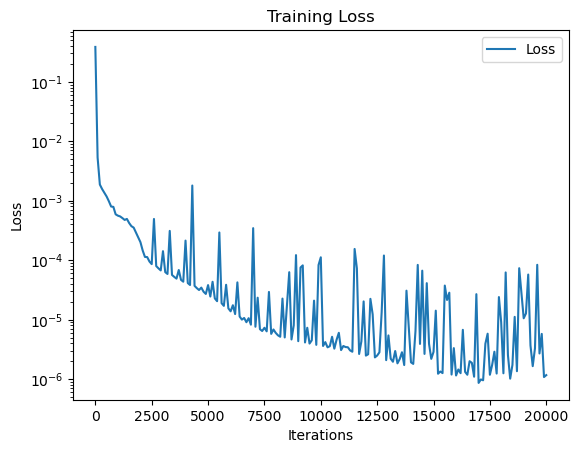

In [165]:
##### Define neural network #####
net10 = Net()
net10 = net10.to(device)


##### Prepare data for training #####
x_in = Variable(torch.from_numpy(x_10.reshape(-1,1)).float(), requires_grad = True).to(device)
y_in = Variable(torch.from_numpy(y_10.reshape(-1,1)).float(), requires_grad = True).to(device)
u_data = Variable(torch.from_numpy(u_10.reshape(-1,1)).float(), requires_grad = True).to(device)
v_data = Variable(torch.from_numpy(v_10.reshape(-1,1)).float(), requires_grad = True).to(device)
p_data = Variable(torch.from_numpy(p_10.reshape(-1,1)).float(), requires_grad = True).to(device)  


##### Xavier Initialization #####
for m in net10.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)


##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net10.parameters(), lr=0.001)
loss_Adam_10 = []


######### Training ########
N_iter_Adam = 20001
print("------ In Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        u_out, v_out, p_out, f_out, g_out = function(net10, x_in, y_in)
        # LOSS FUNCTION:
        u_loss = mse_loss_func(u_out, u_data) 
        v_loss = mse_loss_func(v_out, v_data) 
        p_loss = mse_loss_func(p_out, p_data) 
        loss = u_loss + v_loss + p_loss
        loss.backward()
        return loss
    
    optimizer_adam.step(closure)
    
    if n%100 == 0:
        loss = closure() 
        loss_Adam_10.append(loss.cpu().detach().numpy())
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())

######### Plot Loss over Epochs ########
ep1 = np.arange(1, N_iter_Adam + 1, 100)
plt.semilogy(ep1, loss_Adam_10, label="Loss")
plt.legend()
plt.title('Training Loss' )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

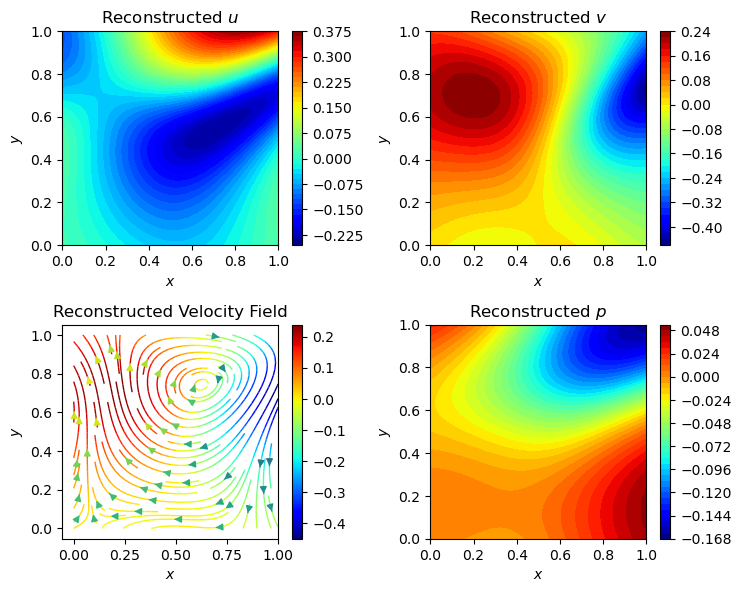

In [166]:
######### Plot Reconstructed Flow over the Entire Domain ########
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net10, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200      # number of points on each edge to construct the mesh to plot the flow
xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
uu, vv, pp = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, uu, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Reconstructed $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, vv, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Reconstructed $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, uu, vv, color=vv, density=1, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Reconstructed Velocity Field' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, pp, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Reconstructed $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

In [167]:
######### Calculate l2 loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net10, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.0270777
0.0029438208
0.014230136
0.008595935


## 20 points:

------ In Adam ------
Adam - Epoch:  0 Training Loss:  0.12827134132385254
Adam - Epoch:  100 Training Loss:  0.003959347028285265
Adam - Epoch:  200 Training Loss:  0.0029725083149969578
Adam - Epoch:  300 Training Loss:  0.0016332585364580154
Adam - Epoch:  400 Training Loss:  0.0010462823556736112
Adam - Epoch:  500 Training Loss:  0.0009804291184991598
Adam - Epoch:  600 Training Loss:  0.0009560630423948169
Adam - Epoch:  700 Training Loss:  0.0009255357435904443
Adam - Epoch:  800 Training Loss:  0.001086776377633214
Adam - Epoch:  900 Training Loss:  0.00084137381054461
Adam - Epoch:  1000 Training Loss:  0.0007540738442912698
Adam - Epoch:  1100 Training Loss:  0.0005453519406728446
Adam - Epoch:  1200 Training Loss:  9.386937017552555e-05
Adam - Epoch:  1300 Training Loss:  0.0002610504743643105
Adam - Epoch:  1400 Training Loss:  3.776734956772998e-05
Adam - Epoch:  1500 Training Loss:  5.546594184124842e-05
Adam - Epoch:  1600 Training Loss:  2.699200740607921e-05
Adam - Epo

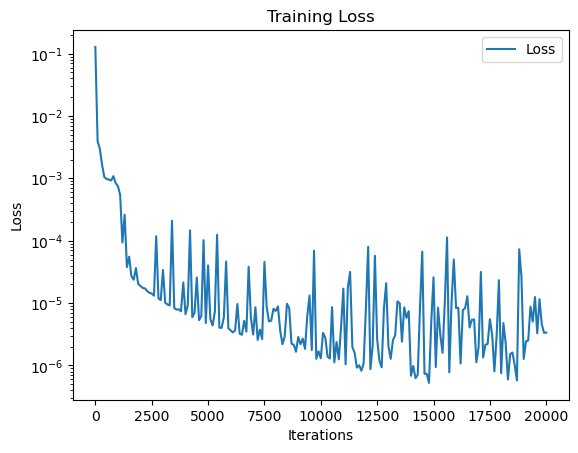

In [156]:
##### Define neural network #####
net20 = Net()
net20 = net20.to(device)


##### Prepare data for training #####
x_in = Variable(torch.from_numpy(x_20.reshape(-1,1)).float(), requires_grad = True).to(device)
y_in = Variable(torch.from_numpy(y_20.reshape(-1,1)).float(), requires_grad = True).to(device)
u_data = Variable(torch.from_numpy(u_20.reshape(-1,1)).float(), requires_grad = True).to(device)
v_data = Variable(torch.from_numpy(v_20.reshape(-1,1)).float(), requires_grad = True).to(device)
p_data = Variable(torch.from_numpy(p_20.reshape(-1,1)).float(), requires_grad = True).to(device)  


##### Xavier Initialization #####
for m in net20.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)


##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net20.parameters(), lr=0.001)
loss_Adam_20 = []


######### Training ########
N_iter_Adam = 20001
print("------ In Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        u_out, v_out, p_out, f_out, g_out = function(net20, x_in, y_in)
        # LOSS FUNCTION:
        u_loss = mse_loss_func(u_out, u_data) 
        v_loss = mse_loss_func(v_out, v_data) 
        p_loss = mse_loss_func(p_out, p_data) 
        loss = u_loss + v_loss + p_loss
        loss.backward()
        return loss
    
    optimizer_adam.step(closure)
    
    if n%100 == 0:
        loss = closure() 
        loss_Adam_20.append(loss.cpu().detach().numpy())
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())

######### Plot Loss over Epochs ########
ep1 = np.arange(1, N_iter_Adam + 1, 100)
plt.semilogy(ep1, loss_Adam_20, label="Loss")
plt.legend()
plt.title('Training Loss' )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

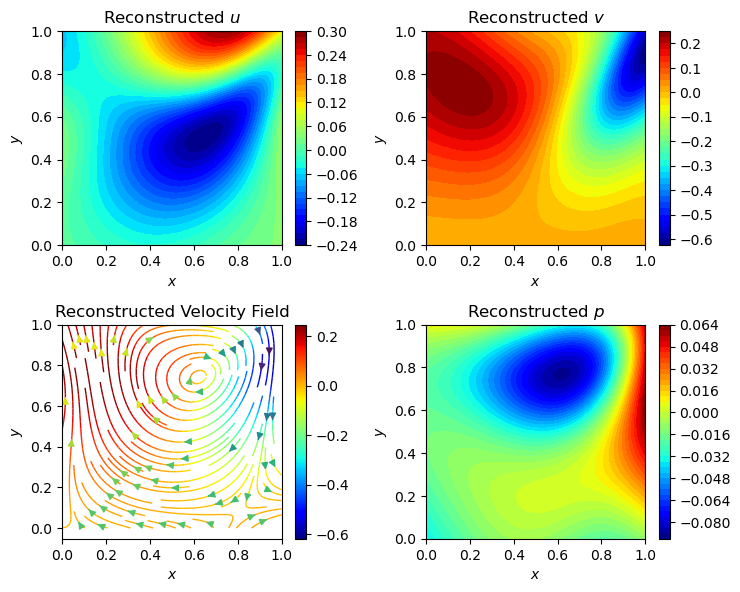

In [157]:
######### Plot Reconstructed Flow over the Entire Domain ########
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net20, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200      # number of points on each edge to construct the mesh to plot the flow
xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
uu, vv, pp = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, uu, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Reconstructed $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, vv, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Reconstructed $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, uu, vv, color=vv, density=1, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Reconstructed Velocity Field' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, pp, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Reconstructed $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

In [158]:
######### Calculate l2 loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net20, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.028373137
0.0030586496
0.00945971
0.007976081


## 30 points:

------ In Adam ------
Adam - Epoch:  0 Training Loss:  0.26627227663993835
Adam - Epoch:  100 Training Loss:  0.0048995050601661205
Adam - Epoch:  200 Training Loss:  0.00372007442638278
Adam - Epoch:  300 Training Loss:  0.003178898710757494
Adam - Epoch:  400 Training Loss:  0.0024105426855385303
Adam - Epoch:  500 Training Loss:  0.001297477283515036
Adam - Epoch:  600 Training Loss:  0.0006973774870857596
Adam - Epoch:  700 Training Loss:  0.0018502335296943784
Adam - Epoch:  800 Training Loss:  0.00033807498402893543
Adam - Epoch:  900 Training Loss:  0.0002708690008148551
Adam - Epoch:  1000 Training Loss:  0.000336047523887828
Adam - Epoch:  1100 Training Loss:  0.00018226917018182576
Adam - Epoch:  1200 Training Loss:  0.00017078363453038037
Adam - Epoch:  1300 Training Loss:  0.00014206417836248875
Adam - Epoch:  1400 Training Loss:  0.00014877330977469683
Adam - Epoch:  1500 Training Loss:  0.00017837982159107924
Adam - Epoch:  1600 Training Loss:  0.00010783291509142146
Adam

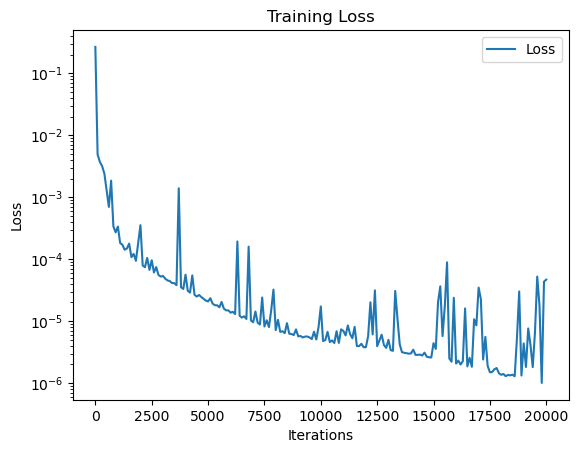

In [159]:
##### Define neural network #####
net30 = Net()
net30 = net30.to(device)


##### Prepare data for training #####
x_in = Variable(torch.from_numpy(x_30.reshape(-1,1)).float(), requires_grad = True).to(device)
y_in = Variable(torch.from_numpy(y_30.reshape(-1,1)).float(), requires_grad = True).to(device)
u_data = Variable(torch.from_numpy(u_30.reshape(-1,1)).float(), requires_grad = True).to(device)
v_data = Variable(torch.from_numpy(v_30.reshape(-1,1)).float(), requires_grad = True).to(device)
p_data = Variable(torch.from_numpy(p_30.reshape(-1,1)).float(), requires_grad = True).to(device)  


##### Xavier Initialization #####
for m in net30.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)


##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net30.parameters(), lr=0.001)
loss_Adam_30 = []


######### Training ########
N_iter_Adam = 20001
print("------ In Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        u_out, v_out, p_out, f_out, g_out = function(net30, x_in, y_in)
        # LOSS FUNCTION:
        u_loss = mse_loss_func(u_out, u_data) 
        v_loss = mse_loss_func(v_out, v_data) 
        p_loss = mse_loss_func(p_out, p_data) 
        loss = u_loss + v_loss + p_loss
        loss.backward()
        return loss
    
    optimizer_adam.step(closure)
    
    if n%100 == 0:
        loss = closure() 
        loss_Adam_30.append(loss.cpu().detach().numpy())
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())

######### Plot Loss over Epochs ########
ep1 = np.arange(1, N_iter_Adam + 1, 100)
plt.semilogy(ep1, loss_Adam_30, label="Loss")
plt.legend()
plt.title('Training Loss' )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

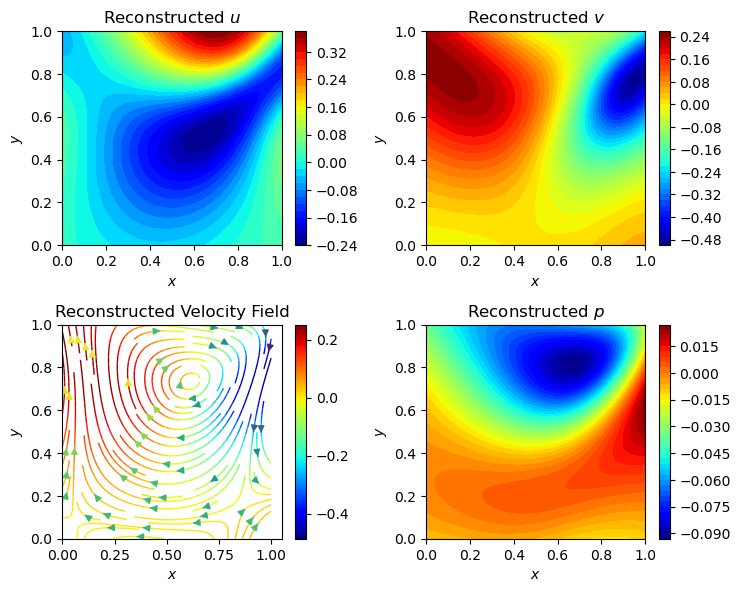

In [160]:
######### Plot Reconstructed Flow over the Entire Domain ########
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net30, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200      # number of points on each edge to construct the mesh to plot the flow
xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
uu, vv, pp = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, uu, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Reconstructed $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, vv, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Reconstructed $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, uu, vv, color=vv, density=1, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Reconstructed Velocity Field' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, pp, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Reconstructed $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

In [161]:
######### Calculate l2 loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net30, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.021813037
0.0026327008
0.01011782
0.008798144


## 40 points:

------ In Adam ------
Adam - Epoch:  0 Training Loss:  0.11284336447715759
Adam - Epoch:  100 Training Loss:  0.008634096942842007
Adam - Epoch:  200 Training Loss:  0.0042909253388643265
Adam - Epoch:  300 Training Loss:  0.004101132974028587
Adam - Epoch:  400 Training Loss:  0.0038953826297074556
Adam - Epoch:  500 Training Loss:  0.0035909274592995644
Adam - Epoch:  600 Training Loss:  0.0030897664837539196
Adam - Epoch:  700 Training Loss:  0.002450097817927599
Adam - Epoch:  800 Training Loss:  0.001267626415938139
Adam - Epoch:  900 Training Loss:  0.0003665988042484969
Adam - Epoch:  1000 Training Loss:  0.00019690483168233186
Adam - Epoch:  1100 Training Loss:  0.00011844438995467499
Adam - Epoch:  1200 Training Loss:  7.296225521713495e-05
Adam - Epoch:  1300 Training Loss:  6.406502507161349e-05
Adam - Epoch:  1400 Training Loss:  5.010581298847683e-05
Adam - Epoch:  1500 Training Loss:  4.604179775924422e-05
Adam - Epoch:  1600 Training Loss:  4.5299530029296875e-05
Adam - 

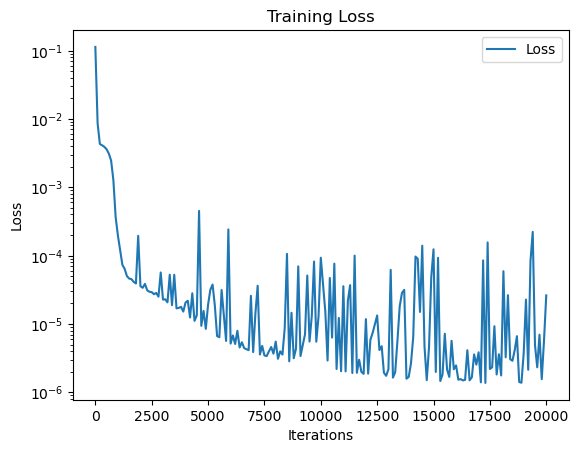

In [162]:
##### Define neural network #####
net40 = Net()
net40 = net40.to(device)


##### Prepare data for training #####
x_in = Variable(torch.from_numpy(x_40.reshape(-1,1)).float(), requires_grad = True).to(device)
y_in = Variable(torch.from_numpy(y_40.reshape(-1,1)).float(), requires_grad = True).to(device)
u_data = Variable(torch.from_numpy(u_40.reshape(-1,1)).float(), requires_grad = True).to(device)
v_data = Variable(torch.from_numpy(v_40.reshape(-1,1)).float(), requires_grad = True).to(device)
p_data = Variable(torch.from_numpy(p_40.reshape(-1,1)).float(), requires_grad = True).to(device)  


##### Xavier Initialization #####
for m in net40.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)


##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net40.parameters(), lr=0.001)
loss_Adam_40 = []


######### Training ########
N_iter_Adam = 20001
print("------ In Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        u_out, v_out, p_out, f_out, g_out = function(net40, x_in, y_in)
        # LOSS FUNCTION:
        u_loss = mse_loss_func(u_out, u_data) 
        v_loss = mse_loss_func(v_out, v_data) 
        p_loss = mse_loss_func(p_out, p_data) 
        loss = u_loss + v_loss + p_loss
        loss.backward()
        return loss
    
    optimizer_adam.step(closure)
    
    if n%100 == 0:
        loss = closure() 
        loss_Adam_40.append(loss.cpu().detach().numpy())
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())

######### Plot Loss over Epochs ########
ep1 = np.arange(1, N_iter_Adam + 1, 100)
plt.semilogy(ep1, loss_Adam_40, label="Loss")
plt.legend()
plt.title('Training Loss' )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

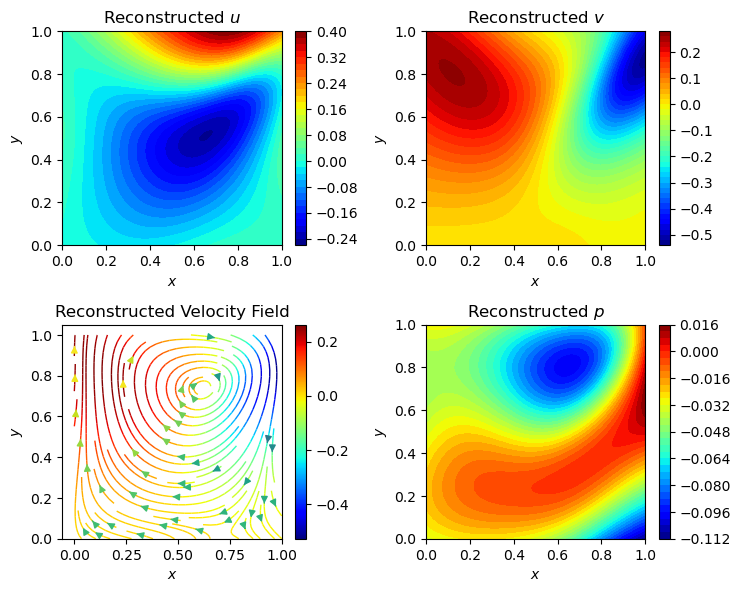

In [163]:
######### Plot Reconstructed Flow over the Entire Domain ########
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net40, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200      # number of points on each edge to construct the mesh to plot the flow
xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
uu, vv, pp = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, uu, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Reconstructed $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, vv, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Reconstructed $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, uu, vv, color=vv, density=1, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Reconstructed Velocity Field' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, pp, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Reconstructed $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

In [164]:
######### Calculate l2 loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net40, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.021638595
0.0024999063
0.009934108
0.008240492


## 50 points

------ In Adam ------
Adam - Epoch:  0 Training Loss:  0.03121446631848812
Adam - Epoch:  100 Training Loss:  0.0021410940680652857
Adam - Epoch:  200 Training Loss:  0.0016235799994319677
Adam - Epoch:  300 Training Loss:  0.0011084984289482236
Adam - Epoch:  400 Training Loss:  0.0004405361833050847
Adam - Epoch:  500 Training Loss:  0.0002275272272527218
Adam - Epoch:  600 Training Loss:  0.00011926301522180438
Adam - Epoch:  700 Training Loss:  0.00018084808834828436
Adam - Epoch:  800 Training Loss:  5.896870425203815e-05
Adam - Epoch:  900 Training Loss:  5.260629768599756e-05
Adam - Epoch:  1000 Training Loss:  4.793877815245651e-05
Adam - Epoch:  1100 Training Loss:  4.41473675891757e-05
Adam - Epoch:  1200 Training Loss:  0.0002566309995017946
Adam - Epoch:  1300 Training Loss:  3.791123890550807e-05
Adam - Epoch:  1400 Training Loss:  3.522710903780535e-05
Adam - Epoch:  1500 Training Loss:  0.00016104748647194356
Adam - Epoch:  1600 Training Loss:  3.072053732466884e-05
Adam

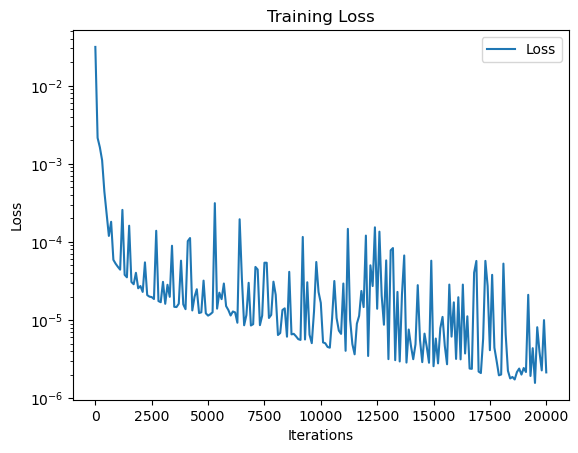

In [150]:
##### Define neural network #####
net50 = Net()
net50 = net50.to(device)


##### Prepare data for training #####
x_in = Variable(torch.from_numpy(x_50.reshape(-1,1)).float(), requires_grad = True).to(device)
y_in = Variable(torch.from_numpy(y_50.reshape(-1,1)).float(), requires_grad = True).to(device)
u_data = Variable(torch.from_numpy(u_50.reshape(-1,1)).float(), requires_grad = True).to(device)
v_data = Variable(torch.from_numpy(v_50.reshape(-1,1)).float(), requires_grad = True).to(device)
p_data = Variable(torch.from_numpy(p_50.reshape(-1,1)).float(), requires_grad = True).to(device)  


##### Xavier Initialization #####
for m in net50.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)



##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net50.parameters(), lr=0.001)
loss_Adam_50 = []


######### Training ########
N_iter_Adam = 20001
print("------ In Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        u_out, v_out, p_out, f_out, g_out = function(net50, x_in, y_in)
        # LOSS FUNCTION:
        u_loss = mse_loss_func(u_out, u_data) 
        v_loss = mse_loss_func(v_out, v_data) 
        p_loss = mse_loss_func(p_out, p_data) 
        loss = u_loss + v_loss + p_loss
        loss.backward()
        return loss
    
    optimizer_adam.step(closure)
    
    if n%100 == 0:
        loss = closure() 
        loss_Adam_50.append(loss.cpu().detach().numpy())
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())



######### Plot Loss over Epochs ########
ep1 = np.arange(1, N_iter_Adam + 1, 100)
plt.semilogy(ep1, loss_Adam_50, label="Loss")
plt.legend()
plt.title('Training Loss' )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

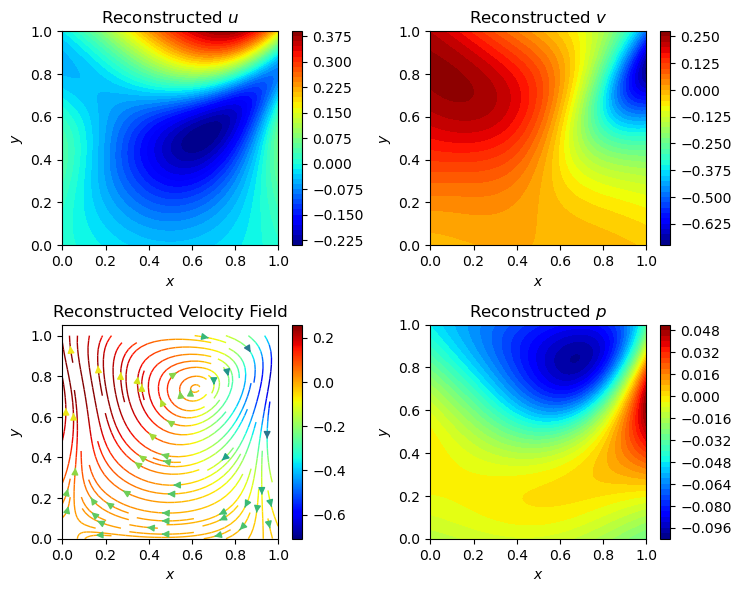

In [151]:
######### Plot Reconstructed Flow over the Entire Domain ########
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net50, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200      # number of points on each edge to construct the mesh to plot the flow
xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
uu, vv, pp = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, uu, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Reconstructed $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, vv, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Reconstructed $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, uu, vv, color=vv, density=1, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Reconstructed Velocity Field' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, pp, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Reconstructed $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

In [152]:
######### Calculate l2 loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net50, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.0254665
0.0027378015
0.012913967
0.013494094


## 100 points

------ In Adam ------
Adam - Epoch:  0 Training Loss:  0.04673616215586662
Adam - Epoch:  100 Training Loss:  0.0038181915879249573
Adam - Epoch:  200 Training Loss:  0.003343855496495962
Adam - Epoch:  300 Training Loss:  0.0023330904077738523
Adam - Epoch:  400 Training Loss:  0.001419178326614201
Adam - Epoch:  500 Training Loss:  0.0003305225691292435
Adam - Epoch:  600 Training Loss:  0.0001582628465257585
Adam - Epoch:  700 Training Loss:  0.00015824279398657382
Adam - Epoch:  800 Training Loss:  0.00010771441884571686
Adam - Epoch:  900 Training Loss:  9.510014206171036e-05
Adam - Epoch:  1000 Training Loss:  8.619230356998742e-05
Adam - Epoch:  1100 Training Loss:  7.931292930152267e-05
Adam - Epoch:  1200 Training Loss:  7.644084689673036e-05
Adam - Epoch:  1300 Training Loss:  7.807750080246478e-05
Adam - Epoch:  1400 Training Loss:  6.479194416897371e-05
Adam - Epoch:  1500 Training Loss:  8.250643440987915e-05
Adam - Epoch:  1600 Training Loss:  5.832273745909333e-05
Adam -

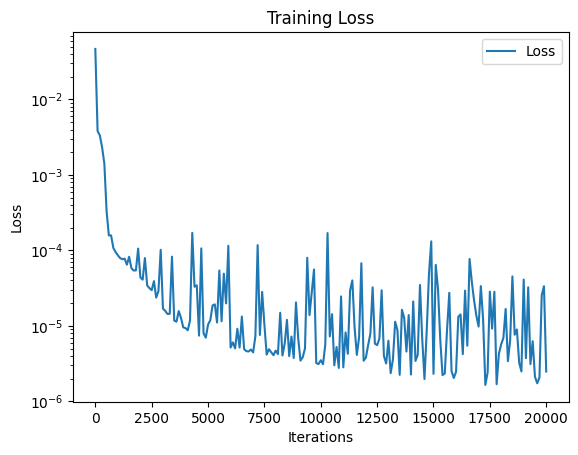

In [ ]:
##### Define neural network #####
net100 = Net()
net100 = net100.to(device)


##### Prepare data for training #####
x_in = Variable(torch.from_numpy(x_100.reshape(-1,1)).float(), requires_grad = True).to(device)
y_in = Variable(torch.from_numpy(y_100.reshape(-1,1)).float(), requires_grad = True).to(device)
u_data = Variable(torch.from_numpy(u_100.reshape(-1,1)).float(), requires_grad = True).to(device)
v_data = Variable(torch.from_numpy(v_100.reshape(-1,1)).float(), requires_grad = True).to(device)
p_data = Variable(torch.from_numpy(p_100.reshape(-1,1)).float(), requires_grad = True).to(device)  


##### Xavier Initialization #####
for m in net100.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)



##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net100.parameters(), lr=0.001)
loss_Adam_100 = []


######### Training ########
N_iter_Adam = 20001
print("------ In Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        u_out, v_out, p_out, f_out, g_out = function(net100, x_in, y_in)
        # LOSS FUNCTION:
        u_loss = mse_loss_func(u_out, u_data) 
        v_loss = mse_loss_func(v_out, v_data) 
        p_loss = mse_loss_func(p_out, p_data) 
        loss = u_loss + v_loss + p_loss
        loss.backward()
        return loss
    
    optimizer_adam.step(closure)
    
    if n%100 == 0:
        loss = closure() 
        loss_Adam_100.append(loss.cpu().detach().numpy())
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())



######### Plot Loss over Epochs ########
ep1 = np.arange(1, N_iter_Adam + 1, 100)
plt.semilogy(ep1, loss_Adam_100, label="Loss")
plt.legend()
plt.title('Training Loss' )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

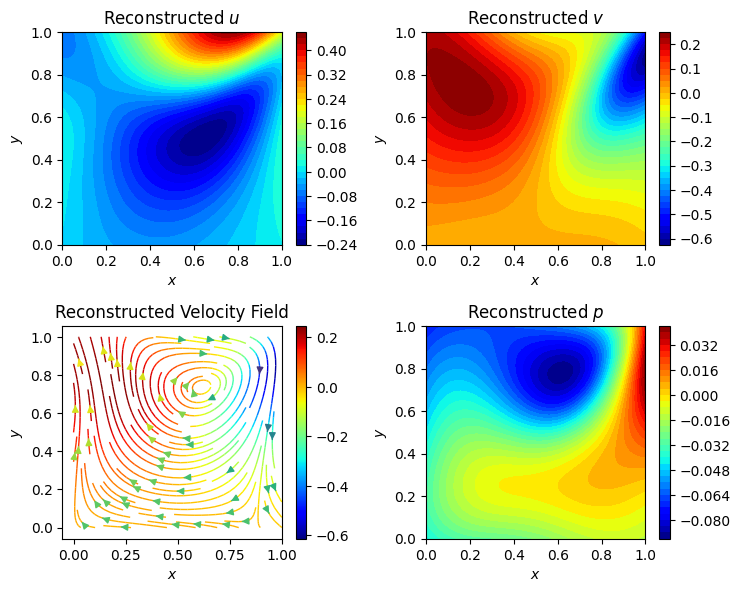

In [ ]:
######### Plot Reconstructed Flow over the Entire Domain ########
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net100, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200      # number of points on each edge to construct the mesh to plot the flow
xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
uu, vv, pp = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, uu, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Reconstructed $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, vv, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Reconstructed $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, uu, vv, color=vv, density=1, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Reconstructed Velocity Field' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, pp, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Reconstructed $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

In [ ]:
######### Calculate l2 loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net100, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.023489421
0.0025698452
0.011171943
0.0113251


## 250 points

------ In Adam ------
Adam - Epoch:  0 Training Loss:  0.19184227287769318
Adam - Epoch:  100 Training Loss:  0.004908151924610138
Adam - Epoch:  200 Training Loss:  0.003999993670731783
Adam - Epoch:  300 Training Loss:  0.0030136052519083023
Adam - Epoch:  400 Training Loss:  0.0018639350309967995
Adam - Epoch:  500 Training Loss:  0.001476826029829681
Adam - Epoch:  600 Training Loss:  0.0011985368328168988
Adam - Epoch:  700 Training Loss:  0.000843353453092277
Adam - Epoch:  800 Training Loss:  0.00047426598030142486
Adam - Epoch:  900 Training Loss:  0.0002738917537499219
Adam - Epoch:  1000 Training Loss:  0.00025737169198691845
Adam - Epoch:  1100 Training Loss:  0.00030972930835559964
Adam - Epoch:  1200 Training Loss:  0.00023683428298681974
Adam - Epoch:  1300 Training Loss:  0.0002623340697027743
Adam - Epoch:  1400 Training Loss:  0.00022039379109628499
Adam - Epoch:  1500 Training Loss:  0.0007156914798542857
Adam - Epoch:  1600 Training Loss:  0.00020404515089467168
Adam

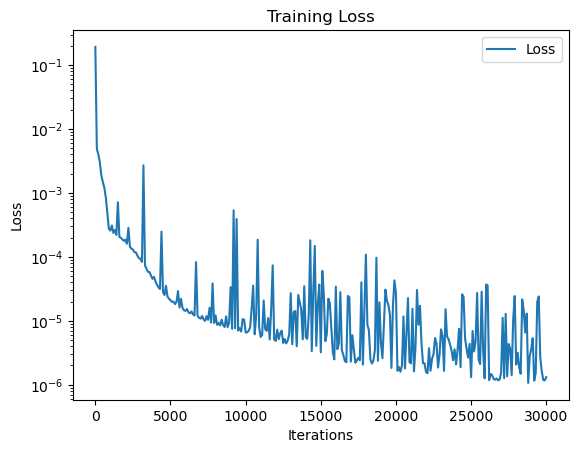

In [116]:
##### Define neural network #####
net250 = Net()
net250 = net250.to(device)


##### Prepare data for training #####
x_in = Variable(torch.from_numpy(x_250.reshape(-1,1)).float(), requires_grad = True).to(device)
y_in = Variable(torch.from_numpy(y_250.reshape(-1,1)).float(), requires_grad = True).to(device)
u_data = Variable(torch.from_numpy(u_250.reshape(-1,1)).float(), requires_grad = True).to(device)
v_data = Variable(torch.from_numpy(v_250.reshape(-1,1)).float(), requires_grad = True).to(device)
p_data = Variable(torch.from_numpy(p_250.reshape(-1,1)).float(), requires_grad = True).to(device)


##### Xavier Initialization #####
for m in net250.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)


##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net250.parameters(), lr=0.001)
loss_Adam_250 = []


######### Training ########
N_iter_Adam = 30001
print("------ In Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        u_out, v_out, p_out, f_out, g_out = function(net250, x_in, y_in)
        # LOSS FUNCTION:
        u_loss = mse_loss_func(u_out, u_data) 
        v_loss = mse_loss_func(v_out, v_data) 
        p_loss = mse_loss_func(p_out, p_data) 
        loss = u_loss + v_loss + p_loss
        loss.backward()
        return loss
    
    optimizer_adam.step(closure)
    
    if n%100 == 0:
        loss = closure() 
        loss_Adam_250.append(loss.cpu().detach().numpy())
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())



######### Plot Loss over Epochs ########
ep1 = np.arange(1, N_iter_Adam + 1, 100)
plt.semilogy(ep1, loss_Adam_250, label="Loss")
plt.legend()
plt.title('Training Loss' )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

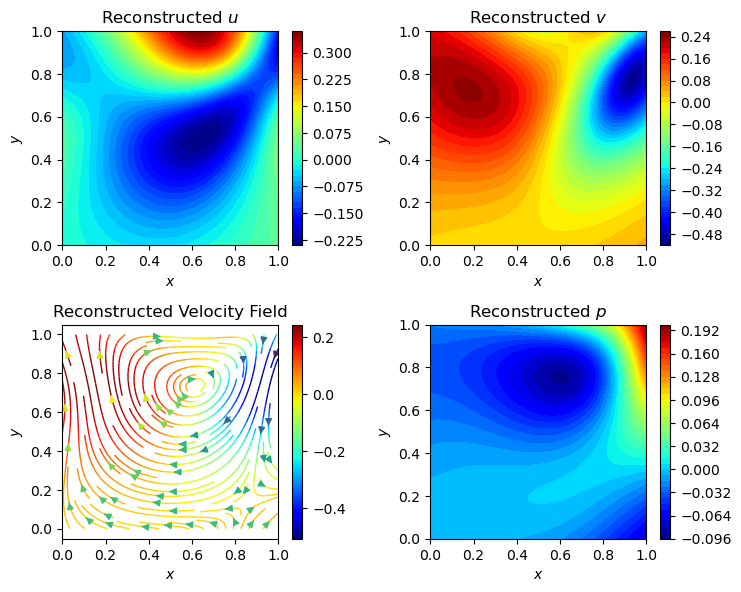

In [117]:
######### Plot Reconstructed Flow over the Entire Domain ########
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net250, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200      # number of points on each edge to construct the mesh to plot the flow
xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
uu, vv, pp = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, uu, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Reconstructed $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, vv, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Reconstructed $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, uu, vv, color=vv, density=1, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Reconstructed Velocity Field' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, pp, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Reconstructed $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

In [118]:
######### Calculate l2 loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net250, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.023934355
0.002976236
0.007780203
0.009095053


## 500 points

------ In Adam ------
Adam - Epoch:  0 Training Loss:  0.04506291449069977
Adam - Epoch:  100 Training Loss:  0.0076962183229625225
Adam - Epoch:  200 Training Loss:  0.0034776695538312197
Adam - Epoch:  300 Training Loss:  0.0019654915668070316
Adam - Epoch:  400 Training Loss:  0.001362800830975175
Adam - Epoch:  500 Training Loss:  0.001147538423538208
Adam - Epoch:  600 Training Loss:  0.0007903231889940798
Adam - Epoch:  700 Training Loss:  0.0003800105769187212
Adam - Epoch:  800 Training Loss:  0.0002790969447232783
Adam - Epoch:  900 Training Loss:  0.00022742038709111512
Adam - Epoch:  1000 Training Loss:  0.0001986714341910556
Adam - Epoch:  1100 Training Loss:  0.00015527803043369204
Adam - Epoch:  1200 Training Loss:  0.00015371284098364413
Adam - Epoch:  1300 Training Loss:  0.00010491716238902882
Adam - Epoch:  1400 Training Loss:  9.451277583139017e-05
Adam - Epoch:  1500 Training Loss:  7.422677299473435e-05
Adam - Epoch:  1600 Training Loss:  0.00031941980705596507
Ada

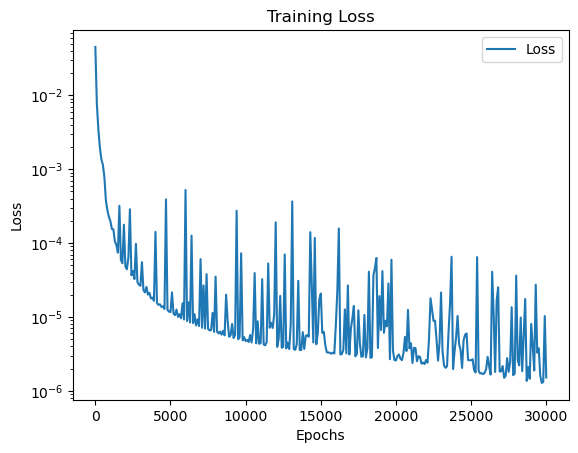

In [113]:
##### Define neural network #####
net500 = Net()
net500 = net500.to(device)


##### Prepare data for training #####
x_in = Variable(torch.from_numpy(x_500.reshape(-1,1)).float(), requires_grad = True).to(device)
y_in = Variable(torch.from_numpy(y_500.reshape(-1,1)).float(), requires_grad = True).to(device)
u_data = Variable(torch.from_numpy(u_500.reshape(-1,1)).float(), requires_grad = True).to(device)
v_data = Variable(torch.from_numpy(v_500.reshape(-1,1)).float(), requires_grad = True).to(device)
p_data = Variable(torch.from_numpy(p_500.reshape(-1,1)).float(), requires_grad = True).to(device)


##### Xavier Initialization #####
for m in net500.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)


##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net500.parameters(), lr=0.001)
loss_Adam_500 = []


######### Training ########
N_iter_Adam = 30001
print("------ In Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        u_out, v_out, p_out, f_out, g_out = function(net500, x_in, y_in)
        # LOSS FUNCTION:
        u_loss = mse_loss_func(u_out, u_data) 
        v_loss = mse_loss_func(v_out, v_data) 
        p_loss = mse_loss_func(p_out, p_data) 
        loss = u_loss + v_loss + p_loss
        loss.backward()
        return loss
    
    optimizer_adam.step(closure)
    
    if n%100 == 0:
        loss = closure() 
        loss_Adam.append(loss.cpu().detach().numpy())
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())



######### Plot Loss over Epochs ########
ep1 = np.arange(1, N_iter_Adam + 1, 100)
plt.semilogy(ep1, loss_Adam, label="Loss")
plt.legend()
plt.title('Training Loss' )
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

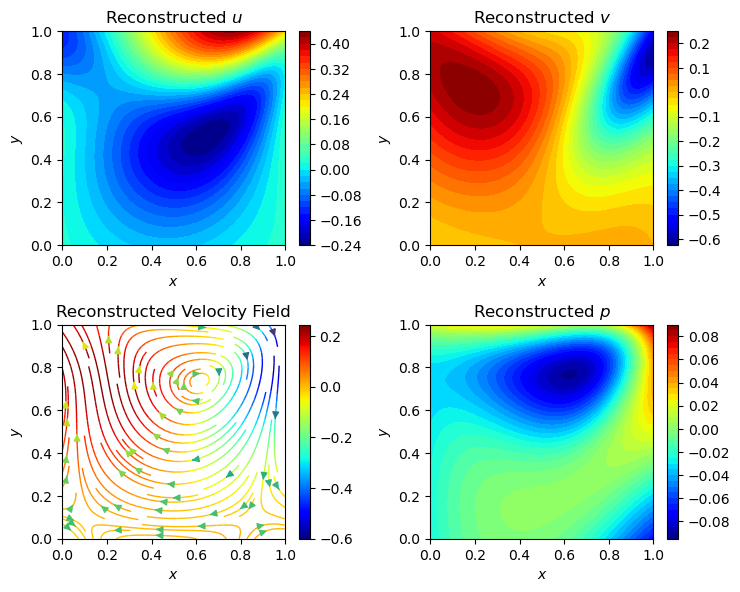

In [114]:
######### Plot Reconstructed Flow over the Entire Domain ########
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net500, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200      # number of points on each edge to construct the mesh to plot the flow
xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
uu, vv, pp = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, uu, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Reconstructed $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, vv, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Reconstructed $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, uu, vv, color=vv, density=1, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Reconstructed Velocity Field' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, pp, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Reconstructed $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

In [115]:
######### Calculate l2 loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net500, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.022394469
0.0024962393
0.008865319
0.008603141


## 1000 points

------ In Adam ------
Adam - Epoch:  0 Training Loss:  0.062044043093919754
Adam - Epoch:  100 Training Loss:  0.00343673606403172
Adam - Epoch:  200 Training Loss:  0.002440629992634058
Adam - Epoch:  300 Training Loss:  0.0018233456648886204
Adam - Epoch:  400 Training Loss:  0.0004253952647559345
Adam - Epoch:  500 Training Loss:  0.00018519459990784526
Adam - Epoch:  600 Training Loss:  0.00042409953312017024
Adam - Epoch:  700 Training Loss:  9.817470709094778e-05
Adam - Epoch:  800 Training Loss:  9.056238195626065e-05
Adam - Epoch:  900 Training Loss:  7.329861546168104e-05
Adam - Epoch:  1000 Training Loss:  8.459490345558152e-05
Adam - Epoch:  1100 Training Loss:  5.767929906141944e-05
Adam - Epoch:  1200 Training Loss:  5.178099308977835e-05
Adam - Epoch:  1300 Training Loss:  4.891385469818488e-05
Adam - Epoch:  1400 Training Loss:  4.314792022341862e-05
Adam - Epoch:  1500 Training Loss:  3.972532067564316e-05
Adam - Epoch:  1600 Training Loss:  3.728861338458955e-05
Adam -

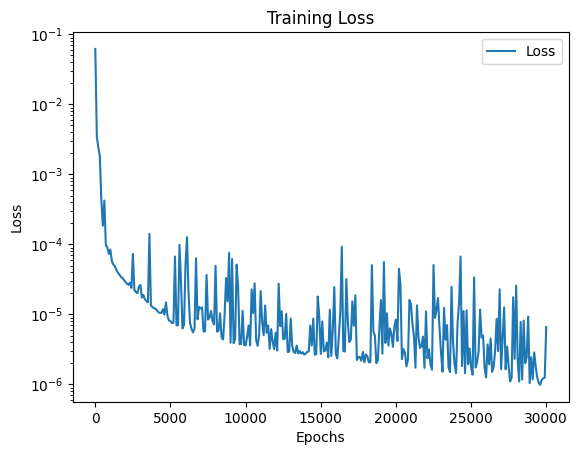

In [ ]:
##### Define neural network #####
net1000 = Net()
net1000 = net1000.to(device)


##### Prepare data for training #####
x_in = Variable(torch.from_numpy(x_1000.reshape(-1,1)).float(), requires_grad = True).to(device)
y_in = Variable(torch.from_numpy(y_1000.reshape(-1,1)).float(), requires_grad = True).to(device)
u_data = Variable(torch.from_numpy(u_1000.reshape(-1,1)).float(), requires_grad = True).to(device)
v_data = Variable(torch.from_numpy(v_1000.reshape(-1,1)).float(), requires_grad = True).to(device)
p_data = Variable(torch.from_numpy(p_1000.reshape(-1,1)).float(), requires_grad = True).to(device)  


##### Xavier Initialization #####
for m in net1000.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)


##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net1000.parameters(), lr=0.001)
loss_Adam_1000 = []


######### Training ########
N_iter_Adam = 30001
print("------ In Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        u_out, v_out, p_out, f_out, g_out = function(net1000, x_in, y_in)
        # LOSS FUNCTION:
        u_loss = mse_loss_func(u_out, u_data) 
        v_loss = mse_loss_func(v_out, v_data) 
        p_loss = mse_loss_func(p_out, p_data) 
        loss = u_loss + v_loss + p_loss
        loss.backward()
        return loss
    
    optimizer_adam.step(closure)
    
    if n%100 == 0:
        loss = closure() 
        loss_Adam_1000.append(loss.cpu().detach().numpy())
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())



######### Plot Loss over Epochs ########
ep1 = np.arange(1, N_iter_Adam + 1, 100)
plt.semilogy(ep1, loss_Adam_1000, label="Loss")
plt.legend()
plt.title('Training Loss' )
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

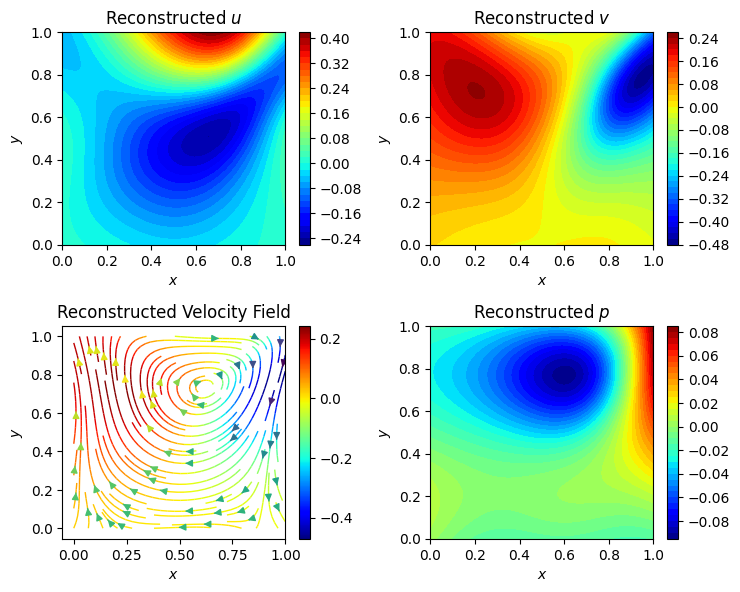

In [ ]:
######### Plot Reconstructed Flow over the Entire Domain ########
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net1000, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200      # number of points on each edge to construct the mesh to plot the flow
xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
uu, vv, pp = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, uu, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Reconstructed $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, vv, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Reconstructed $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, uu, vv, color=vv, density=1, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Reconstructed Velocity Field' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, pp, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Reconstructed $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

In [ ]:
######### Calculate l2 loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net1000, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.02082288
0.0024017938
0.009026436
0.010578715


# What if I sample boundary points?

In [173]:
# randomly sample N points from a square patch
def sample_boundary(N, left, right):
    len = x.shape[0]
    x_train = np.array([])
    y_train = np.array([])
    u_train = np.array([])
    v_train = np.array([])
    p_train = np.array([])
    
    i = 0
    while i <= N:
        idx = np.random.choice(len, 1, replace=False)
        x_sample = x[idx,:]
        y_sample = y[idx,:]
        u_sample = u[idx,:]
        v_sample = v[idx,:]
        p_sample = p[idx,:]
        
        if not(left <= x_sample <= right and left <= y_sample <= right): # around the boundary
            i = i + 1
            x_train = np.append(x_train, x_sample)
            y_train = np.append(y_train, y_sample)
            u_train = np.append(u_train, u_sample)
            v_train = np.append(v_train, v_sample)
            p_train = np.append(p_train, p_sample)      
   
    return x_train, y_train, u_train, v_train, p_train

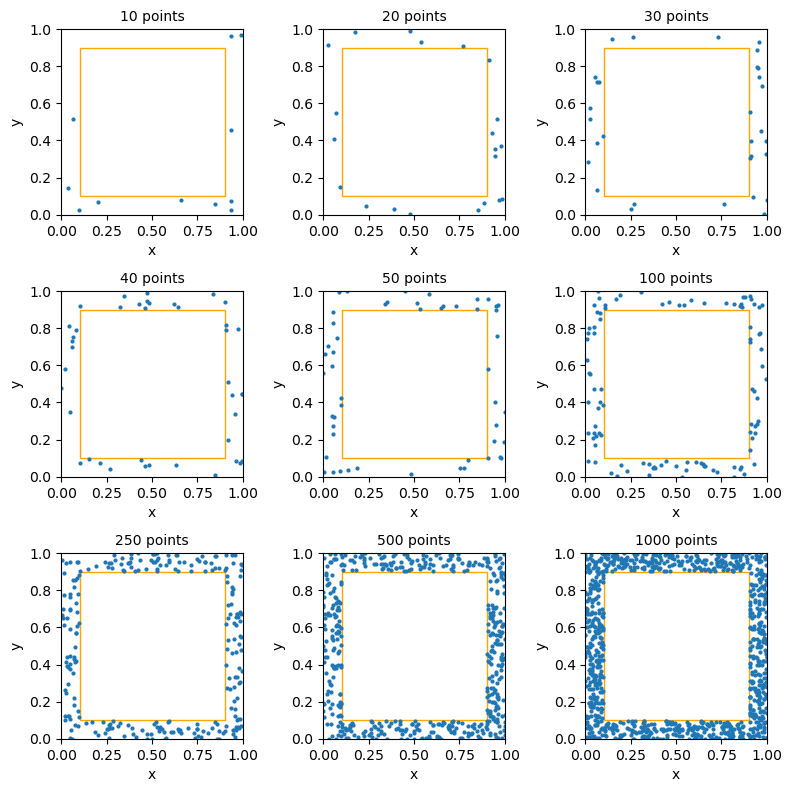

In [227]:
# Sample random points inside the sqaure patch
left = 0.1
right = 0.9

x_10, y_10, u_10, v_10, p_10 = sample_boundary(10, left, right)
x_20, y_20, u_20, v_20, p_20 = sample_boundary(20, left, right)
x_30, y_30, u_30, v_30, p_30 = sample_boundary(30, left, right)
x_40, y_40, u_40, v_40, p_40 = sample_boundary(40, left, right)
x_50, y_50, u_50, v_50, p_50 = sample_boundary(50, left, right)
x_100, y_100, u_100, v_100, p_100 = sample_boundary(100, left, right)
x_250, y_250, u_250, v_250, p_250 = sample_boundary(250, left, right)
x_500, y_500, u_500, v_500, p_500 = sample_boundary(500, left, right)
x_1000, y_1000, u_1000, v_1000, p_1000 = sample_boundary(1000, left, right)


# Visualize the sampled points
fig, axs = plt.subplots(3, 3, figsize=(8, 8), sharey=False)

axs[0, 0].set_xlim(0, 1)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].plot(x_10, y_10, "o", markersize=2)
axs[0, 0].add_patch(Rectangle((left, left), 0.8, 0.8, edgecolor = 'orange', fill=False))
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
axs[0, 0].set_title("10 points", fontsize=10)

axs[0, 1].set_xlim(0, 1)
axs[0, 1].set_ylim(0, 1)
axs[0, 1].plot(x_20, y_20, "o", markersize=2)
axs[0, 1].add_patch(Rectangle((left, left), 0.8, 0.8, edgecolor = 'orange', fill=False))
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
axs[0, 1].set_title("20 points", fontsize=10)

axs[0, 2].set_xlim(0, 1)
axs[0, 2].set_ylim(0, 1)
axs[0, 2].plot(x_30, y_30, "o", markersize=2)
axs[0, 2].add_patch(Rectangle((left, left), 0.8, 0.8, edgecolor = 'orange', fill=False))
axs[0, 2].set_xlabel("x")
axs[0, 2].set_ylabel("y")
axs[0, 2].set_title("30 points", fontsize=10)

axs[1, 0].set_xlim(0, 1)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].plot(x_40, y_40, "o", markersize=2)
axs[1, 0].add_patch(Rectangle((left, left), 0.8, 0.8, edgecolor = 'orange', fill=False))
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel("y")
axs[1, 0].set_title("40 points", fontsize=10)

axs[1, 1].set_xlim(0, 1)
axs[1, 1].set_ylim(0, 1)
axs[1, 1].plot(x_50, y_50, "o", markersize=2)
axs[1, 1].add_patch(Rectangle((left, left), 0.8, 0.8, edgecolor = 'orange', fill=False))
axs[1, 1].set_xlabel("x")
axs[1, 1].set_ylabel("y")
axs[1, 1].set_title("50 points", fontsize=10)

axs[1, 2].set_xlim(0, 1)
axs[1, 2].set_ylim(0, 1)
axs[1, 2].plot(x_100, y_100, "o", markersize=2)
axs[1, 2].add_patch(Rectangle((left, left), 0.8, 0.8, edgecolor = 'orange', fill=False))
axs[1, 2].set_xlabel("x")
axs[1, 2].set_ylabel("y")
axs[1, 2].set_title("100 points", fontsize=10)

axs[2, 0].set_xlim(0, 1)
axs[2, 0].set_ylim(0, 1)
axs[2, 0].plot(x_250, y_250, "o", markersize=2)
axs[2, 0].add_patch(Rectangle((left, left), 0.8, 0.8, edgecolor = 'orange', fill=False))
axs[2, 0].set_xlabel("x")
axs[2, 0].set_ylabel("y")
axs[2, 0].set_title("250 points", fontsize=10)

axs[2, 1].set_xlim(0, 1)
axs[2, 1].set_ylim(0, 1)
axs[2, 1].plot(x_500, y_500, "o", markersize=2)
axs[2, 1].add_patch(Rectangle((left, left), 0.8, 0.8, edgecolor = 'orange', fill=False))
axs[2, 1].set_xlabel("x")
axs[2, 1].set_ylabel("y")
axs[2, 1].set_title("500 points", fontsize=10)

axs[2, 2].set_xlim(0, 1)
axs[2, 2].set_ylim(0, 1)
axs[2, 2].plot(x_1000, y_1000, "o", markersize=2)
axs[2, 2].add_patch(Rectangle((left, left), 0.8, 0.8, edgecolor = 'orange', fill=False))
axs[2, 2].set_xlabel("x")
axs[2, 2].set_ylabel("y")
axs[2, 2].set_title("1000 points", fontsize=10)

fig.tight_layout(pad=1.0)
plt.show()

## 10 points:

------ In Adam ------
Adam - Epoch:  0 Training Loss:  0.2346748262643814
Adam - Epoch:  100 Training Loss:  0.06318008154630661
Adam - Epoch:  200 Training Loss:  0.002904470544308424
Adam - Epoch:  300 Training Loss:  0.0009244828834198415
Adam - Epoch:  400 Training Loss:  0.0006291880854405463
Adam - Epoch:  500 Training Loss:  0.000485386437503621
Adam - Epoch:  600 Training Loss:  0.00041615034569986165
Adam - Epoch:  700 Training Loss:  0.0003537764132488519
Adam - Epoch:  800 Training Loss:  0.0003217532648704946
Adam - Epoch:  900 Training Loss:  0.00028099160408601165
Adam - Epoch:  1000 Training Loss:  0.0002720544289331883
Adam - Epoch:  1100 Training Loss:  0.00023715129646006972
Adam - Epoch:  1200 Training Loss:  0.00032255667611025274
Adam - Epoch:  1300 Training Loss:  0.00020560184202622622
Adam - Epoch:  1400 Training Loss:  0.0011471319012343884
Adam - Epoch:  1500 Training Loss:  0.00017913267947733402
Adam - Epoch:  1600 Training Loss:  0.0012352467747405171
Adam 

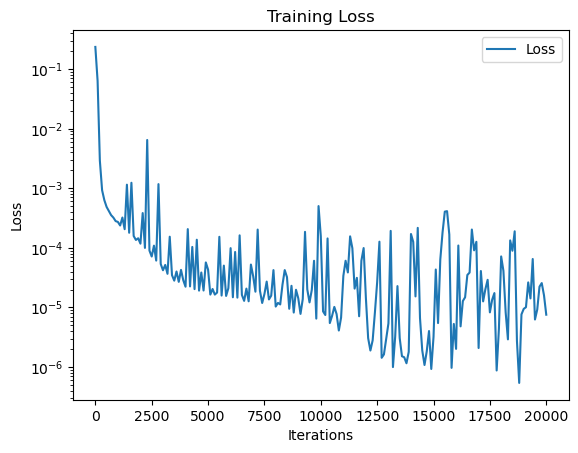

In [201]:
##### Define neural network #####
net10_b = Net()
net10_b = net10_b.to(device)


##### Prepare data for training #####
x_in = Variable(torch.from_numpy(x_10.reshape(-1,1)).float(), requires_grad = True).to(device)
y_in = Variable(torch.from_numpy(y_10.reshape(-1,1)).float(), requires_grad = True).to(device)
u_data = Variable(torch.from_numpy(u_10.reshape(-1,1)).float(), requires_grad = True).to(device)
v_data = Variable(torch.from_numpy(v_10.reshape(-1,1)).float(), requires_grad = True).to(device)
p_data = Variable(torch.from_numpy(p_10.reshape(-1,1)).float(), requires_grad = True).to(device)  


##### Xavier Initialization #####
for m in net10_b.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)


##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net10_b.parameters(), lr=0.001)
loss_Adam_10_b = []


######### Training ########
N_iter_Adam = 20001
print("------ In Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        u_out, v_out, p_out, f_out, g_out = function(net10_b, x_in, y_in)
        # LOSS FUNCTION:
        u_loss = mse_loss_func(u_out, u_data) 
        v_loss = mse_loss_func(v_out, v_data) 
        p_loss = mse_loss_func(p_out, p_data) 
        loss = u_loss + v_loss + p_loss
        loss.backward()
        return loss
    
    optimizer_adam.step(closure)
    
    if n%100 == 0:
        loss = closure() 
        loss_Adam_10_b.append(loss.cpu().detach().numpy())
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())

######### Plot Loss over Epochs ########
ep1 = np.arange(1, N_iter_Adam + 1, 100)
plt.semilogy(ep1, loss_Adam_10_b, label="Loss")
plt.legend()
plt.title('Training Loss' )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

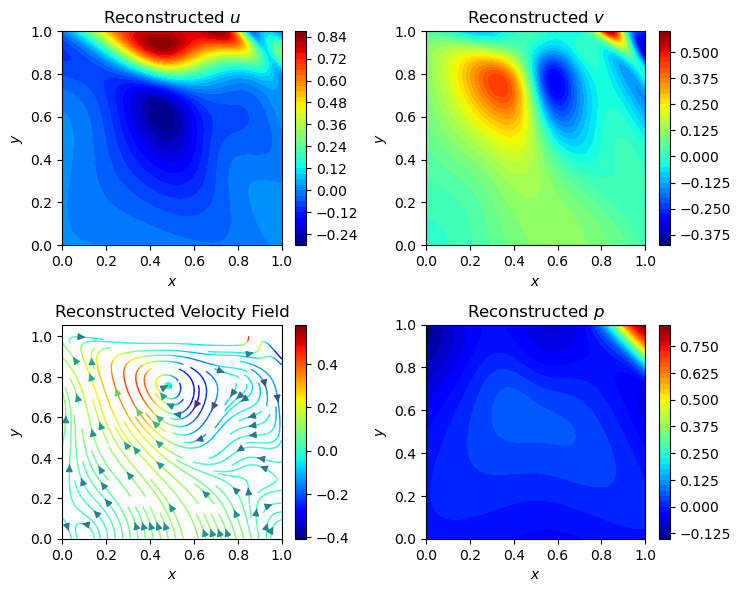

In [202]:
######### Plot Reconstructed Flow over the Entire Domain ########
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net10_b, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200      # number of points on each edge to construct the mesh to plot the flow
xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
uu, vv, pp = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, uu, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Reconstructed $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, vv, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Reconstructed $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, uu, vv, color=vv, density=1, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Reconstructed Velocity Field' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, pp, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Reconstructed $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

In [203]:
######### Calculate l2 loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net10_b, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.03072242
0.0020629913
0.007655327
0.007751954


## 20 points:

------ In Adam ------
Adam - Epoch:  0 Training Loss:  0.2530909776687622
Adam - Epoch:  100 Training Loss:  0.06915467232465744
Adam - Epoch:  200 Training Loss:  0.008617541752755642
Adam - Epoch:  300 Training Loss:  0.00589880533516407
Adam - Epoch:  400 Training Loss:  0.004328795708715916
Adam - Epoch:  500 Training Loss:  0.0035179101396352053
Adam - Epoch:  600 Training Loss:  0.0029279945883899927
Adam - Epoch:  700 Training Loss:  0.002253349404782057
Adam - Epoch:  800 Training Loss:  0.0016466326778754592
Adam - Epoch:  900 Training Loss:  0.0009169590775854886
Adam - Epoch:  1000 Training Loss:  0.0005480135441757739
Adam - Epoch:  1100 Training Loss:  0.00028771033976227045
Adam - Epoch:  1200 Training Loss:  0.0006803213618695736
Adam - Epoch:  1300 Training Loss:  0.00016313842206727713
Adam - Epoch:  1400 Training Loss:  0.0001933490129886195
Adam - Epoch:  1500 Training Loss:  0.00014465684944298118
Adam - Epoch:  1600 Training Loss:  0.0001385381619911641
Adam - Epoc

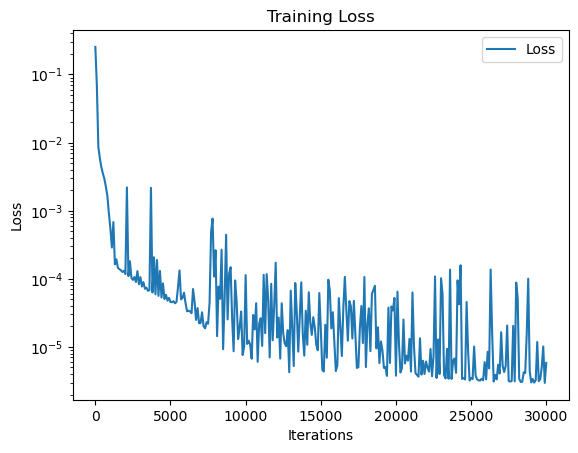

In [198]:
##### Define neural network #####
net20_b = Net()
net20_b = net20_b.to(device)


##### Prepare data for training #####
x_in = Variable(torch.from_numpy(x_20.reshape(-1,1)).float(), requires_grad = True).to(device)
y_in = Variable(torch.from_numpy(y_20.reshape(-1,1)).float(), requires_grad = True).to(device)
u_data = Variable(torch.from_numpy(u_20.reshape(-1,1)).float(), requires_grad = True).to(device)
v_data = Variable(torch.from_numpy(v_20.reshape(-1,1)).float(), requires_grad = True).to(device)
p_data = Variable(torch.from_numpy(p_20.reshape(-1,1)).float(), requires_grad = True).to(device)  


##### Xavier Initialization #####
for m in net20_b.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)


##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net20_b.parameters(), lr=0.001)
loss_Adam_20_b = []


######### Training ########
N_iter_Adam = 30001
print("------ In Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        u_out, v_out, p_out, f_out, g_out = function(net20_b, x_in, y_in)
        # LOSS FUNCTION:
        u_loss = mse_loss_func(u_out, u_data) 
        v_loss = mse_loss_func(v_out, v_data) 
        p_loss = mse_loss_func(p_out, p_data) 
        loss = u_loss + v_loss + p_loss
        loss.backward()
        return loss
    
    optimizer_adam.step(closure)
    
    if n%100 == 0:
        loss = closure() 
        loss_Adam_20_b.append(loss.cpu().detach().numpy())
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())

######### Plot Loss over Epochs ########
ep1 = np.arange(1, N_iter_Adam + 1, 100)
plt.semilogy(ep1, loss_Adam_20_b, label="Loss")
plt.legend()
plt.title('Training Loss' )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

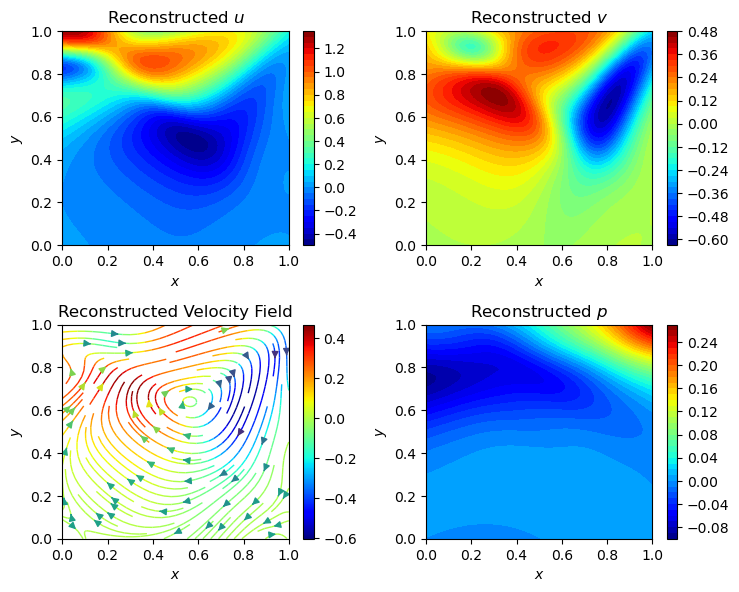

In [199]:
######### Plot Reconstructed Flow over the Entire Domain ########
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net20_b, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200      # number of points on each edge to construct the mesh to plot the flow
xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
uu, vv, pp = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, uu, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Reconstructed $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, vv, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Reconstructed $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, uu, vv, color=vv, density=1, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Reconstructed Velocity Field' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, pp, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Reconstructed $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

In [200]:
######### Calculate l2 loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net20_b, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.07840385
0.005390118
0.008049583
0.008300055


## 30 points:

------ In Adam ------
Adam - Epoch:  0 Training Loss:  0.16046865284442902
Adam - Epoch:  100 Training Loss:  0.04877568781375885
Adam - Epoch:  200 Training Loss:  0.024370139464735985
Adam - Epoch:  300 Training Loss:  0.008010813035070896
Adam - Epoch:  400 Training Loss:  0.004873048514127731
Adam - Epoch:  500 Training Loss:  0.0037693087942898273
Adam - Epoch:  600 Training Loss:  0.0029363054782152176
Adam - Epoch:  700 Training Loss:  0.0018815225921571255
Adam - Epoch:  800 Training Loss:  0.0013543128734454513
Adam - Epoch:  900 Training Loss:  0.002043006243184209
Adam - Epoch:  1000 Training Loss:  0.0006952708354219794
Adam - Epoch:  1100 Training Loss:  0.0005553718074224889
Adam - Epoch:  1200 Training Loss:  0.0005652973777614534
Adam - Epoch:  1300 Training Loss:  0.0005798798520117998
Adam - Epoch:  1400 Training Loss:  0.0004137684591114521
Adam - Epoch:  1500 Training Loss:  0.0004461939388420433
Adam - Epoch:  1600 Training Loss:  0.00022726960014551878
Adam - Epoc

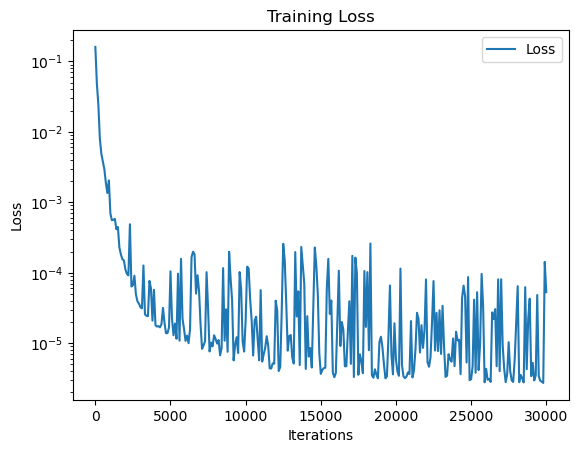

In [228]:
##### Define neural network #####
net30_b = Net()
net30_b = net30_b.to(device)


##### Prepare data for training #####
x_in = Variable(torch.from_numpy(x_30.reshape(-1,1)).float(), requires_grad = True).to(device)
y_in = Variable(torch.from_numpy(y_30.reshape(-1,1)).float(), requires_grad = True).to(device)
u_data = Variable(torch.from_numpy(u_30.reshape(-1,1)).float(), requires_grad = True).to(device)
v_data = Variable(torch.from_numpy(v_30.reshape(-1,1)).float(), requires_grad = True).to(device)
p_data = Variable(torch.from_numpy(p_30.reshape(-1,1)).float(), requires_grad = True).to(device)  


##### Xavier Initialization #####
for m in net30_b.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)


##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net30_b.parameters(), lr=0.001)
loss_Adam_30_b = []


######### Training ########
N_iter_Adam = 30001
print("------ In Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        u_out, v_out, p_out, f_out, g_out = function(net30_b, x_in, y_in)
        # LOSS FUNCTION:
        u_loss = mse_loss_func(u_out, u_data) 
        v_loss = mse_loss_func(v_out, v_data) 
        p_loss = mse_loss_func(p_out, p_data) 
        loss = u_loss + v_loss + p_loss
        loss.backward()
        return loss
    
    optimizer_adam.step(closure)
    
    if n%100 == 0:
        loss = closure() 
        loss_Adam_30_b.append(loss.cpu().detach().numpy())
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())

######### Plot Loss over Epochs ########
ep1 = np.arange(1, N_iter_Adam + 1, 100)
plt.semilogy(ep1, loss_Adam_30_b, label="Loss")
plt.legend()
plt.title('Training Loss' )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

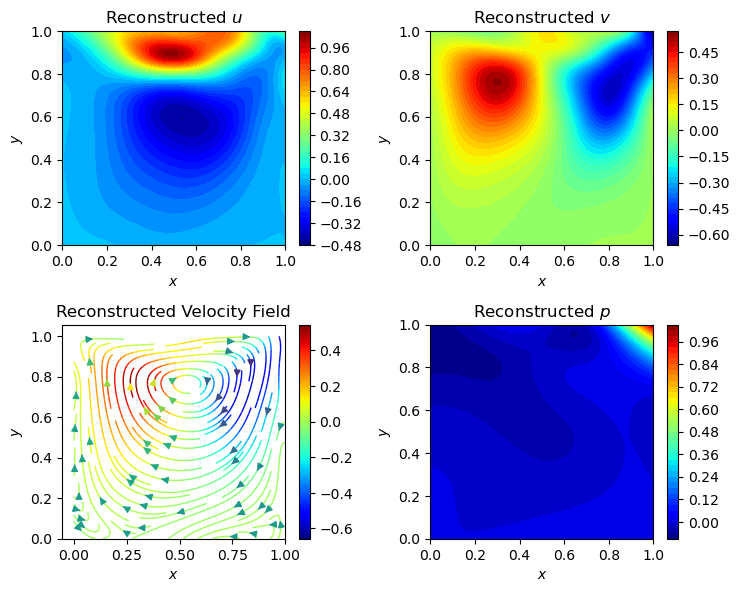

In [229]:
######### Plot Reconstructed Flow over the Entire Domain ########
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net30_b, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200      # number of points on each edge to construct the mesh to plot the flow
xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
uu, vv, pp = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, uu, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Reconstructed $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, vv, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Reconstructed $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, uu, vv, color=vv, density=1, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Reconstructed Velocity Field' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, pp, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Reconstructed $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

In [230]:
######### Calculate l2 loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net30_b, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.032476008
0.0023867658
0.0043921284
0.005748618


## 40 points:

------ In Adam ------
Adam - Epoch:  0 Training Loss:  0.2096731811761856
Adam - Epoch:  100 Training Loss:  0.016232285648584366
Adam - Epoch:  200 Training Loss:  0.009797239676117897
Adam - Epoch:  300 Training Loss:  0.005847069900482893
Adam - Epoch:  400 Training Loss:  0.005012268200516701
Adam - Epoch:  500 Training Loss:  0.0044859303161501884
Adam - Epoch:  600 Training Loss:  0.00455796904861927
Adam - Epoch:  700 Training Loss:  0.0036149811930954456
Adam - Epoch:  800 Training Loss:  0.0033372428733855486
Adam - Epoch:  900 Training Loss:  0.0026670678053051233
Adam - Epoch:  1000 Training Loss:  0.0020171867217868567
Adam - Epoch:  1100 Training Loss:  0.0016686125891283154
Adam - Epoch:  1200 Training Loss:  0.0015088650397956371
Adam - Epoch:  1300 Training Loss:  0.002205511089414358
Adam - Epoch:  1400 Training Loss:  0.0010684509761631489
Adam - Epoch:  1500 Training Loss:  0.0009195840684697032
Adam - Epoch:  1600 Training Loss:  0.0008198433788493276
Adam - Epoch: 

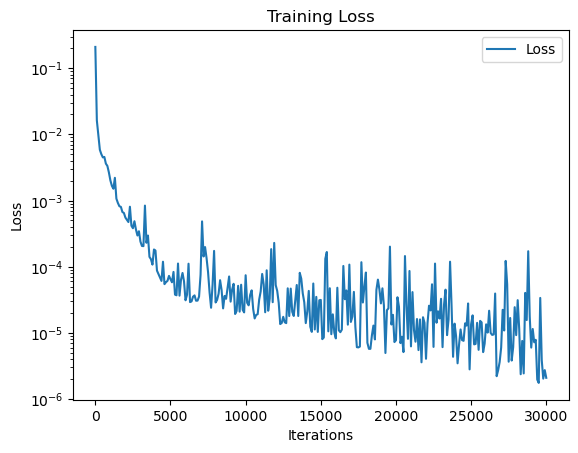

In [223]:
##### Define neural network #####
net40_b = Net()
net40_b = net40_b.to(device)


##### Prepare data for training #####
x_in = Variable(torch.from_numpy(x_40.reshape(-1,1)).float(), requires_grad = True).to(device)
y_in = Variable(torch.from_numpy(y_40.reshape(-1,1)).float(), requires_grad = True).to(device)
u_data = Variable(torch.from_numpy(u_40.reshape(-1,1)).float(), requires_grad = True).to(device)
v_data = Variable(torch.from_numpy(v_40.reshape(-1,1)).float(), requires_grad = True).to(device)
p_data = Variable(torch.from_numpy(p_40.reshape(-1,1)).float(), requires_grad = True).to(device)  


##### Xavier Initialization #####
for m in net40_b.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)


##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net40_b.parameters(), lr=0.001)
loss_Adam_40_b = []


######### Training ########
N_iter_Adam = 30001
print("------ In Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        u_out, v_out, p_out, f_out, g_out = function(net40_b, x_in, y_in)
        # LOSS FUNCTION:
        u_loss = mse_loss_func(u_out, u_data) 
        v_loss = mse_loss_func(v_out, v_data) 
        p_loss = mse_loss_func(p_out, p_data) 
        loss = u_loss + v_loss + p_loss
        loss.backward()
        return loss
    
    optimizer_adam.step(closure)
    
    if n%100 == 0:
        loss = closure() 
        loss_Adam_40_b.append(loss.cpu().detach().numpy())
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())

######### Plot Loss over Epochs ########
ep1 = np.arange(1, N_iter_Adam + 1, 100)
plt.semilogy(ep1, loss_Adam_40_b, label="Loss")
plt.legend()
plt.title('Training Loss' )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

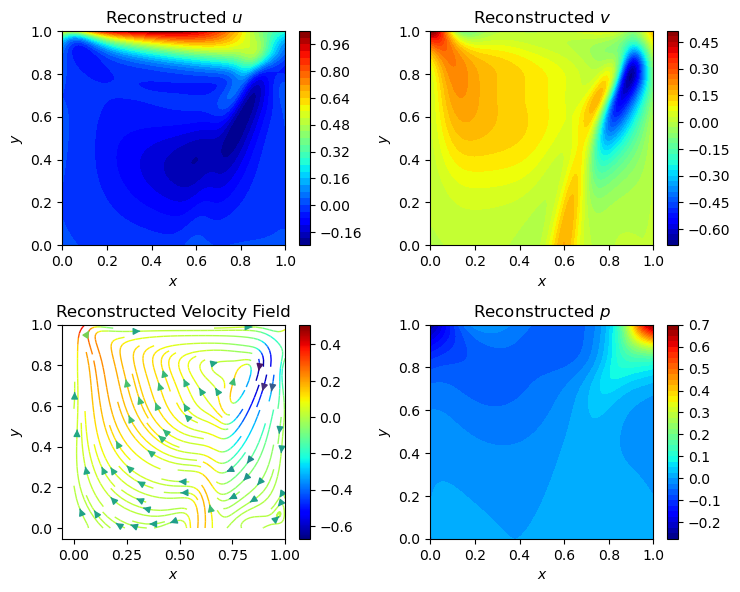

In [224]:
######### Plot Reconstructed Flow over the Entire Domain ########
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net40_b, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200      # number of points on each edge to construct the mesh to plot the flow
xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
uu, vv, pp = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, uu, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Reconstructed $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, vv, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Reconstructed $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, uu, vv, color=vv, density=1, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Reconstructed Velocity Field' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, pp, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Reconstructed $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

In [225]:
######### Calculate l2 loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net40_b, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.01103642
0.0010462662
0.0056757526
0.007911167


## 50 points

------ In Adam ------
Adam - Epoch:  0 Training Loss:  0.10159385204315186
Adam - Epoch:  100 Training Loss:  0.027555860579013824
Adam - Epoch:  200 Training Loss:  0.008604859933257103
Adam - Epoch:  300 Training Loss:  0.006947259418666363
Adam - Epoch:  400 Training Loss:  0.010417042300105095
Adam - Epoch:  500 Training Loss:  0.006284135393798351
Adam - Epoch:  600 Training Loss:  0.011051604524254799
Adam - Epoch:  700 Training Loss:  0.005986436735838652
Adam - Epoch:  800 Training Loss:  0.005872056353837252
Adam - Epoch:  900 Training Loss:  0.005785783752799034
Adam - Epoch:  1000 Training Loss:  0.005658992100507021
Adam - Epoch:  1100 Training Loss:  0.005530836526304483
Adam - Epoch:  1200 Training Loss:  0.005390137434005737
Adam - Epoch:  1300 Training Loss:  0.0052073304541409016
Adam - Epoch:  1400 Training Loss:  0.004991617985069752
Adam - Epoch:  1500 Training Loss:  0.004693012684583664
Adam - Epoch:  1600 Training Loss:  0.0043090712279081345
Adam - Epoch:  1700 

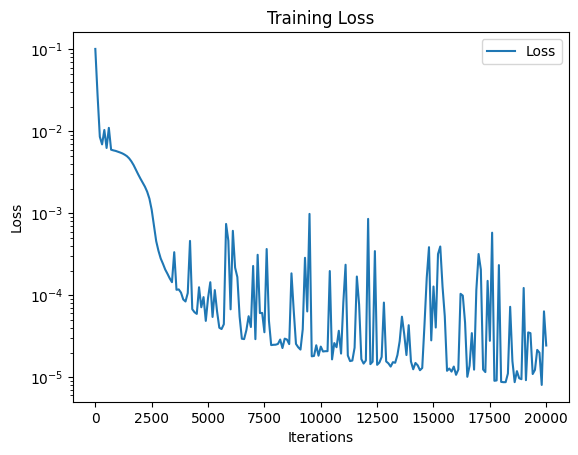

In [ ]:
##### Define neural network #####
net50_b = Net()
net50_b = net50_b.to(device)


##### Prepare data for training #####
x_in = Variable(torch.from_numpy(x_50.reshape(-1,1)).float(), requires_grad = True).to(device)
y_in = Variable(torch.from_numpy(y_50.reshape(-1,1)).float(), requires_grad = True).to(device)
u_data = Variable(torch.from_numpy(u_50.reshape(-1,1)).float(), requires_grad = True).to(device)
v_data = Variable(torch.from_numpy(v_50.reshape(-1,1)).float(), requires_grad = True).to(device)
p_data = Variable(torch.from_numpy(p_50.reshape(-1,1)).float(), requires_grad = True).to(device)  


##### Xavier Initialization #####
for m in net50_b.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)



##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net50_b.parameters(), lr=0.001)
loss_Adam_50_b = []


######### Training ########
N_iter_Adam = 20001
print("------ In Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        u_out, v_out, p_out, f_out, g_out = function(net50_b, x_in, y_in)
        # LOSS FUNCTION:
        u_loss = mse_loss_func(u_out, u_data) 
        v_loss = mse_loss_func(v_out, v_data) 
        p_loss = mse_loss_func(p_out, p_data) 
        loss = u_loss + v_loss + p_loss
        loss.backward()
        return loss
    
    optimizer_adam.step(closure)
    
    if n%100 == 0:
        loss = closure() 
        loss_Adam_50_b.append(loss.cpu().detach().numpy())
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())



######### Plot Loss over Epochs ########
ep1 = np.arange(1, N_iter_Adam + 1, 100)
plt.semilogy(ep1, loss_Adam_50_b, label="Loss")
plt.legend()
plt.title('Training Loss' )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

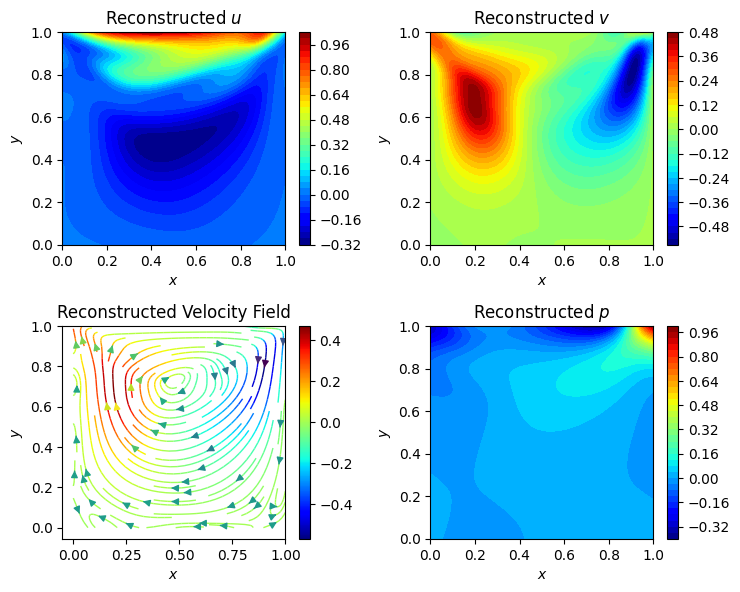

In [ ]:
######### Plot Reconstructed Flow over the Entire Domain ########
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net50_b, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200      # number of points on each edge to construct the mesh to plot the flow
xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
uu, vv, pp = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, uu, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Reconstructed $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, vv, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Reconstructed $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, uu, vv, color=vv, density=1, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Reconstructed Velocity Field' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, pp, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Reconstructed $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

In [ ]:
######### Calculate l2 loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net50_b, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.008112545
0.00064039376
0.00756297
0.0060099442


## 100 points

------ In Adam ------
Adam - Epoch:  0 Training Loss:  0.207301527261734
Adam - Epoch:  100 Training Loss:  0.07846687734127045
Adam - Epoch:  200 Training Loss:  0.02342050150036812
Adam - Epoch:  300 Training Loss:  0.01549348421394825
Adam - Epoch:  400 Training Loss:  0.012087110430002213
Adam - Epoch:  500 Training Loss:  0.01078881323337555
Adam - Epoch:  600 Training Loss:  0.009812158532440662
Adam - Epoch:  700 Training Loss:  0.00792940054088831
Adam - Epoch:  800 Training Loss:  0.006167631130665541
Adam - Epoch:  900 Training Loss:  0.00478406623005867
Adam - Epoch:  1000 Training Loss:  0.0038033900782465935
Adam - Epoch:  1100 Training Loss:  0.0032372125424444675
Adam - Epoch:  1200 Training Loss:  0.0029011962469667196
Adam - Epoch:  1300 Training Loss:  0.002627825364470482
Adam - Epoch:  1400 Training Loss:  0.002337354002520442
Adam - Epoch:  1500 Training Loss:  0.002118352334946394
Adam - Epoch:  1600 Training Loss:  0.0018292837776243687
Adam - Epoch:  1700 Traini

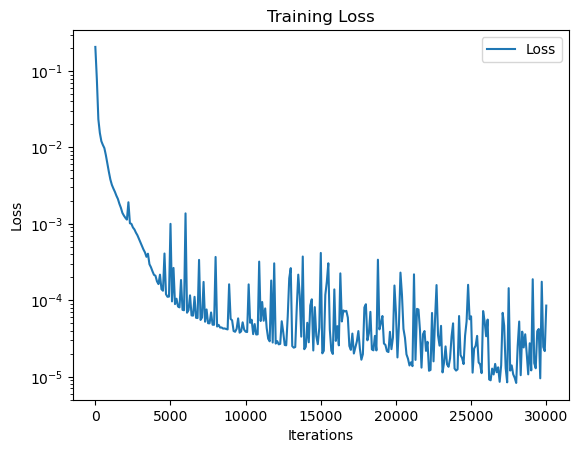

In [187]:
##### Define neural network #####
net100_b = Net()
net100_b = net100_b.to(device)


##### Prepare data for training #####
x_in = Variable(torch.from_numpy(x_100.reshape(-1,1)).float(), requires_grad = True).to(device)
y_in = Variable(torch.from_numpy(y_100.reshape(-1,1)).float(), requires_grad = True).to(device)
u_data = Variable(torch.from_numpy(u_100.reshape(-1,1)).float(), requires_grad = True).to(device)
v_data = Variable(torch.from_numpy(v_100.reshape(-1,1)).float(), requires_grad = True).to(device)
p_data = Variable(torch.from_numpy(p_100.reshape(-1,1)).float(), requires_grad = True).to(device)  


##### Xavier Initialization #####
for m in net100_b.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)



##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net100_b.parameters(), lr=0.001)
loss_Adam_100_b = []


######### Training ########
N_iter_Adam = 30001
print("------ In Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        u_out, v_out, p_out, f_out, g_out = function(net100_b, x_in, y_in)
        # LOSS FUNCTION:
        u_loss = mse_loss_func(u_out, u_data) 
        v_loss = mse_loss_func(v_out, v_data) 
        p_loss = mse_loss_func(p_out, p_data) 
        loss = u_loss + v_loss + p_loss
        loss.backward()
        return loss
    
    optimizer_adam.step(closure)
    
    if n%100 == 0:
        loss = closure() 
        loss_Adam_100_b.append(loss.cpu().detach().numpy())
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())



######### Plot Loss over Epochs ########
ep1 = np.arange(1, N_iter_Adam + 1, 100)
plt.semilogy(ep1, loss_Adam_100_b, label="Loss")
plt.legend()
plt.title('Training Loss' )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

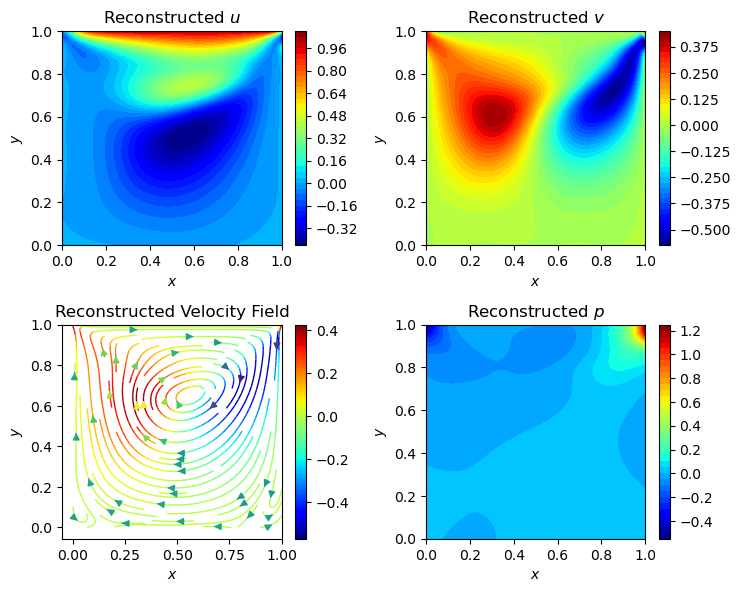

In [188]:
######### Plot Reconstructed Flow over the Entire Domain ########
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net100_b, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200      # number of points on each edge to construct the mesh to plot the flow
xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
uu, vv, pp = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, uu, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Reconstructed $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, vv, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Reconstructed $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, uu, vv, color=vv, density=1, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Reconstructed Velocity Field' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, pp, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Reconstructed $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

In [189]:
######### Calculate l2 loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net100_b, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.01287513
0.0009655366
0.0024079026
0.0037308016


## 250 points

------ In Adam ------
Adam - Epoch:  0 Training Loss:  0.24511876702308655
Adam - Epoch:  100 Training Loss:  0.05331895872950554
Adam - Epoch:  200 Training Loss:  0.021601222455501556
Adam - Epoch:  300 Training Loss:  0.01562693528831005
Adam - Epoch:  400 Training Loss:  0.01299936231225729
Adam - Epoch:  500 Training Loss:  0.01112060621380806
Adam - Epoch:  600 Training Loss:  0.009434103034436703
Adam - Epoch:  700 Training Loss:  0.00724281370639801
Adam - Epoch:  800 Training Loss:  0.005423819646239281
Adam - Epoch:  900 Training Loss:  0.004576904233545065
Adam - Epoch:  1000 Training Loss:  0.004179862793534994
Adam - Epoch:  1100 Training Loss:  0.004300201311707497
Adam - Epoch:  1200 Training Loss:  0.003149053081870079
Adam - Epoch:  1300 Training Loss:  0.0032081357203423977
Adam - Epoch:  1400 Training Loss:  0.0024206852540373802
Adam - Epoch:  1500 Training Loss:  0.0023864551912993193
Adam - Epoch:  1600 Training Loss:  0.0018331680912524462
Adam - Epoch:  1700 Tra

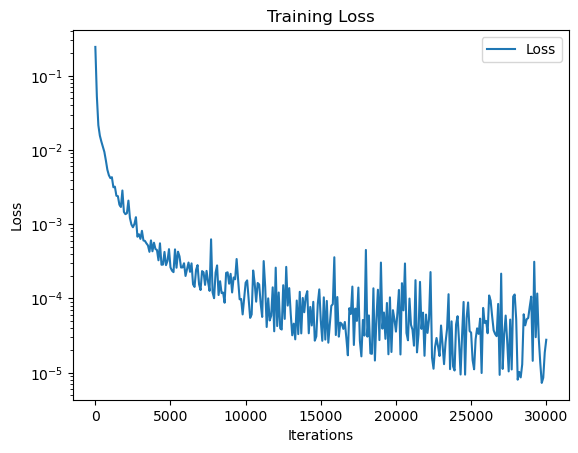

In [210]:
##### Define neural network #####
net250_b = Net()
net250_b = net250_b.to(device)


##### Prepare data for training #####
x_in = Variable(torch.from_numpy(x_250.reshape(-1,1)).float(), requires_grad = True).to(device)
y_in = Variable(torch.from_numpy(y_250.reshape(-1,1)).float(), requires_grad = True).to(device)
u_data = Variable(torch.from_numpy(u_250.reshape(-1,1)).float(), requires_grad = True).to(device)
v_data = Variable(torch.from_numpy(v_250.reshape(-1,1)).float(), requires_grad = True).to(device)
p_data = Variable(torch.from_numpy(p_250.reshape(-1,1)).float(), requires_grad = True).to(device)


##### Xavier Initialization #####
for m in net250_b.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)


##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net250_b.parameters(), lr=0.001)
loss_Adam_250_b = []


######### Training ########
N_iter_Adam = 30001
print("------ In Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        u_out, v_out, p_out, f_out, g_out = function(net250_b, x_in, y_in)
        # LOSS FUNCTION:
        u_loss = mse_loss_func(u_out, u_data) 
        v_loss = mse_loss_func(v_out, v_data) 
        p_loss = mse_loss_func(p_out, p_data) 
        loss = u_loss + v_loss + p_loss
        loss.backward()
        return loss
    
    optimizer_adam.step(closure)
    
    if n%100 == 0:
        loss = closure() 
        loss_Adam_250_b.append(loss.cpu().detach().numpy())
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())



######### Plot Loss over Epochs ########
ep1 = np.arange(1, N_iter_Adam + 1, 100)
plt.semilogy(ep1, loss_Adam_250_b, label="Loss")
plt.legend()
plt.title('Training Loss' )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

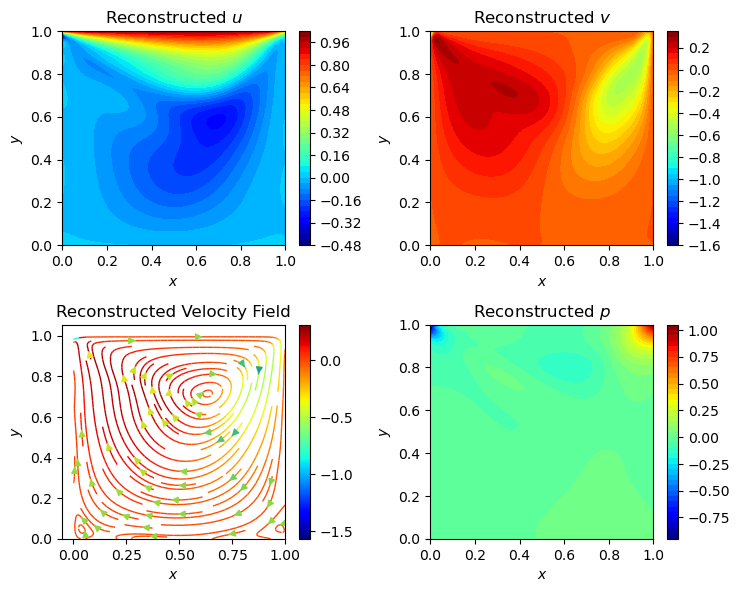

In [211]:
######### Plot Reconstructed Flow over the Entire Domain ########
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net250_b, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200      # number of points on each edge to construct the mesh to plot the flow
xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
uu, vv, pp = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, uu, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Reconstructed $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, vv, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Reconstructed $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, uu, vv, color=vv, density=1, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Reconstructed Velocity Field' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, pp, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Reconstructed $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

In [212]:
######### Calculate l2 loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net250_b, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.0016131613
0.0007330523
0.0030115999
0.0052370913


## 500 points

------ In Adam ------
Adam - Epoch:  0 Training Loss:  0.22099292278289795
Adam - Epoch:  100 Training Loss:  0.04523046687245369
Adam - Epoch:  200 Training Loss:  0.024697117507457733
Adam - Epoch:  300 Training Loss:  0.01607229746878147
Adam - Epoch:  400 Training Loss:  0.013769222423434258
Adam - Epoch:  500 Training Loss:  0.01690979115664959
Adam - Epoch:  600 Training Loss:  0.011736668646335602
Adam - Epoch:  700 Training Loss:  0.011117957532405853
Adam - Epoch:  800 Training Loss:  0.010365389287471771
Adam - Epoch:  900 Training Loss:  0.00947534292936325
Adam - Epoch:  1000 Training Loss:  0.00925653800368309
Adam - Epoch:  1100 Training Loss:  0.0068956222385168076
Adam - Epoch:  1200 Training Loss:  0.005510639399290085
Adam - Epoch:  1300 Training Loss:  0.004357676953077316
Adam - Epoch:  1400 Training Loss:  0.0035946695134043694
Adam - Epoch:  1500 Training Loss:  0.003412337740883231
Adam - Epoch:  1600 Training Loss:  0.0031476663425564766
Adam - Epoch:  1700 Trai

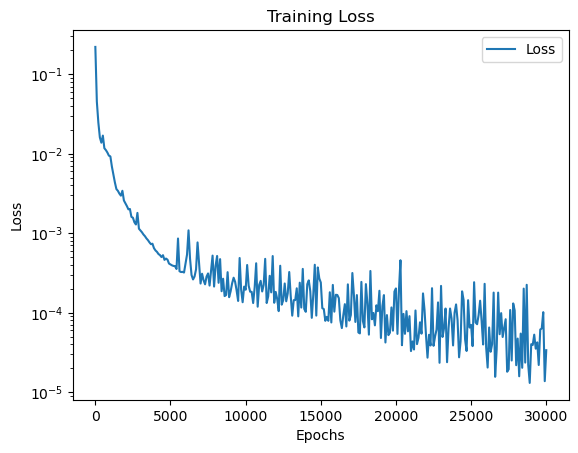

In [217]:
##### Define neural network #####
net500_b = Net()
net500_b = net500_b.to(device)


##### Prepare data for training #####
x_in = Variable(torch.from_numpy(x_500.reshape(-1,1)).float(), requires_grad = True).to(device)
y_in = Variable(torch.from_numpy(y_500.reshape(-1,1)).float(), requires_grad = True).to(device)
u_data = Variable(torch.from_numpy(u_500.reshape(-1,1)).float(), requires_grad = True).to(device)
v_data = Variable(torch.from_numpy(v_500.reshape(-1,1)).float(), requires_grad = True).to(device)
p_data = Variable(torch.from_numpy(p_500.reshape(-1,1)).float(), requires_grad = True).to(device)


##### Xavier Initialization #####
for m in net500_b.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)


##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net500_b.parameters(), lr=0.001)
loss_Adam_500_b = []


######### Training ########
N_iter_Adam = 30001
print("------ In Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        u_out, v_out, p_out, f_out, g_out = function(net500_b, x_in, y_in)
        # LOSS FUNCTION:
        u_loss = mse_loss_func(u_out, u_data) 
        v_loss = mse_loss_func(v_out, v_data) 
        p_loss = mse_loss_func(p_out, p_data) 
        loss = u_loss + v_loss + p_loss
        loss.backward()
        return loss
    
    optimizer_adam.step(closure)
    
    if n%100 == 0:
        loss = closure() 
        loss_Adam_500_b.append(loss.cpu().detach().numpy())
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())



######### Plot Loss over Epochs ########
ep1 = np.arange(1, N_iter_Adam + 1, 100)
plt.semilogy(ep1, loss_Adam_500_b, label="Loss")
plt.legend()
plt.title('Training Loss' )
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

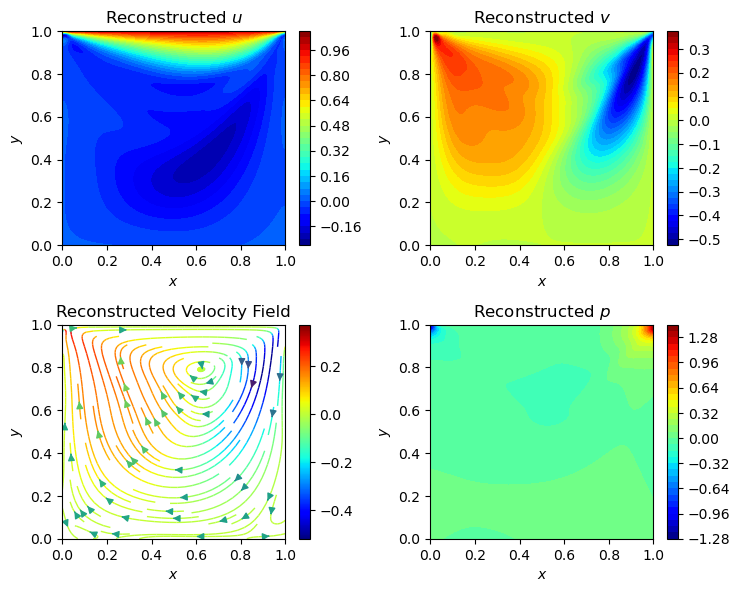

In [218]:
######### Plot Reconstructed Flow over the Entire Domain ########
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net500_b, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200      # number of points on each edge to construct the mesh to plot the flow
xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
uu, vv, pp = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, uu, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Reconstructed $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, vv, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Reconstructed $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, uu, vv, color=vv, density=1, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Reconstructed Velocity Field' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, pp, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Reconstructed $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

In [219]:
######### Calculate l2 loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net500_b, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.001940442
0.00014705822
0.002536014
0.0052781617


## 1000 points

------ In Adam ------
Adam - Epoch:  0 Training Loss:  0.40673452615737915
Adam - Epoch:  100 Training Loss:  0.09303658455610275
Adam - Epoch:  200 Training Loss:  0.06661675125360489
Adam - Epoch:  300 Training Loss:  0.05094300955533981
Adam - Epoch:  400 Training Loss:  0.04621122404932976
Adam - Epoch:  500 Training Loss:  0.0414804071187973
Adam - Epoch:  600 Training Loss:  0.03671744093298912
Adam - Epoch:  700 Training Loss:  0.0329495444893837
Adam - Epoch:  800 Training Loss:  0.02862226963043213
Adam - Epoch:  900 Training Loss:  0.023489568382501602
Adam - Epoch:  1000 Training Loss:  0.01902056857943535
Adam - Epoch:  1100 Training Loss:  0.015997547656297684
Adam - Epoch:  1200 Training Loss:  0.013483032584190369
Adam - Epoch:  1300 Training Loss:  0.01163497194647789
Adam - Epoch:  1400 Training Loss:  0.01023662555962801
Adam - Epoch:  1500 Training Loss:  0.009255604818463326
Adam - Epoch:  1600 Training Loss:  0.008173157460987568
Adam - Epoch:  1700 Training Loss: 

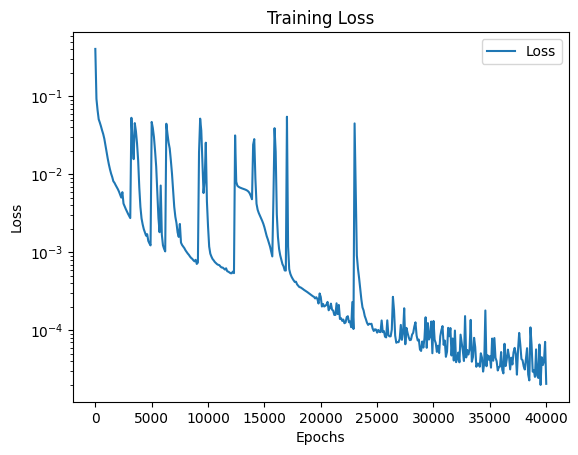

In [ ]:
##### Define neural network #####
net1000_b = Net()
net1000_b = net1000_b.to(device)


##### Prepare data for training #####
x_in = Variable(torch.from_numpy(x_1000.reshape(-1,1)).float(), requires_grad = True).to(device)
y_in = Variable(torch.from_numpy(y_1000.reshape(-1,1)).float(), requires_grad = True).to(device)
u_data = Variable(torch.from_numpy(u_1000.reshape(-1,1)).float(), requires_grad = True).to(device)
v_data = Variable(torch.from_numpy(v_1000.reshape(-1,1)).float(), requires_grad = True).to(device)
p_data = Variable(torch.from_numpy(p_1000.reshape(-1,1)).float(), requires_grad = True).to(device)  


##### Xavier Initialization #####
for m in net1000_b.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)


##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net1000_b.parameters(), lr=0.001)
loss_Adam_1000_b = []


######### Training ########
N_iter_Adam = 40001
print("------ In Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        u_out, v_out, p_out, f_out, g_out = function(net1000_b, x_in, y_in)
        # LOSS FUNCTION:
        u_loss = mse_loss_func(u_out, u_data) 
        v_loss = mse_loss_func(v_out, v_data) 
        p_loss = mse_loss_func(p_out, p_data) 
        loss = u_loss + v_loss + p_loss
        loss.backward()
        return loss
    
    optimizer_adam.step(closure)
    
    if n%100 == 0:
        loss = closure() 
        loss_Adam_1000_b.append(loss.cpu().detach().numpy())
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())



######### Plot Loss over Epochs ########
ep1 = np.arange(1, N_iter_Adam + 1, 100)
plt.semilogy(ep1, loss_Adam_1000_b, label="Loss")
plt.legend()
plt.title('Training Loss' )
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

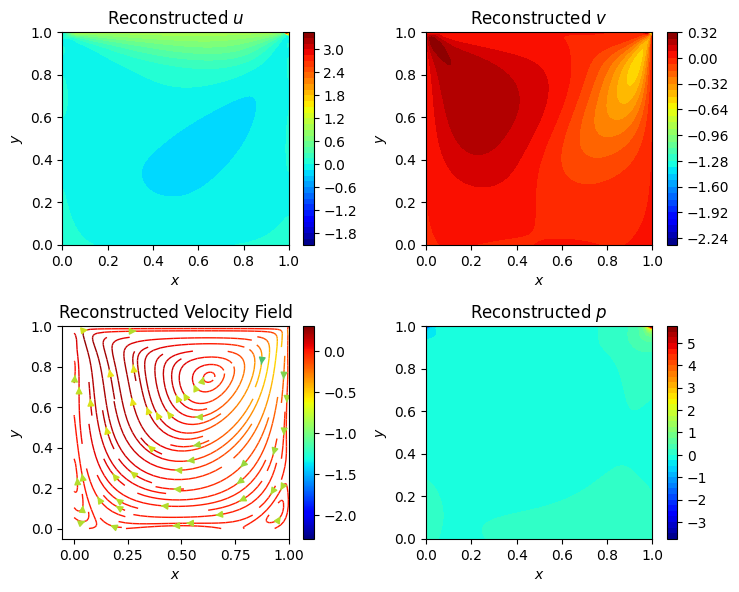

In [ ]:
######### Plot Reconstructed Flow over the Entire Domain ########
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net1000_b, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200      # number of points on each edge to construct the mesh to plot the flow
xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
uu, vv, pp = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, uu, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Reconstructed $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, vv, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Reconstructed $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, uu, vv, color=vv, density=1, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Reconstructed Velocity Field' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, pp, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Reconstructed $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()

In [ ]:
######### Calculate l2 loss between reconstructed and actual flow field ########
N_test = 1000
len = x.shape[0]

U_loss = []
P_loss = []

for i in range(100):     # calculate the l2 loss for 50 times
    idx = np.random.choice(len, N_test, replace=False)      # randomly select N_test data points
    x_test = x[idx,:]
    y_test = y[idx,:]
    u_test = u[idx,:]
    v_test = v[idx,:]
    p_test = p[idx,:]     # testing data

    x_in = Variable(torch.from_numpy(x_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    y_in = Variable(torch.from_numpy(y_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    u_test = Variable(torch.from_numpy(u_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    v_test = Variable(torch.from_numpy(v_test.reshape(-1,1)).float(), requires_grad = True).to(device)
    p_test = Variable(torch.from_numpy(p_test.reshape(-1,1)).float(), requires_grad = True).to(device) 

    u_out, v_out, p_out, f_out, g_out = function(net1000_b, x_in, y_in)     # evaluate
    u_loss = mse_loss_func(u_out, u_test) 
    v_loss = mse_loss_func(v_out, v_test) 
    velocity_loss = u_loss + v_loss
    p_loss = mse_loss_func(p_out, p_test) 

    U_loss.append(velocity_loss.cpu().detach().numpy())
    P_loss.append(p_loss.cpu().detach().numpy())

print(np.mean(U_loss))      # report the mean of the loss 
print(np.std(U_loss))  
print(np.mean(P_loss))
print(np.std(P_loss))

0.0014973516
0.0024856625
0.002271583
0.0041187177
